In [417]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import shap
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,mean_squared_error, precision_score, recall_score,confusion_matrix,f1_score,r2_score,log_loss,brier_score_loss
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN  
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,QuantileTransformer
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import VotingClassifier
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings('ignore')
import os
from mplsoccer.pitch import Pitch
from sklearn.metrics import classification_report


print("Imported")

Imported


In [323]:
# Loading the SHOT EVENTS dataset
dataset = pd.read_csv('Shots_leagues_14_20.csv')
data_team_ratings =  pd.read_csv('FIFA_Club_Ratings.csv')

dataset['X_coord'] = dataset['X_coord'].round(2)
dataset['Y_coord'] = dataset['Y_coord'].round(2)
dataset['Y_coord_angle'] = (1 - abs(dataset['Y_coord'] - 0.50) * 2).round(2)

dataset['is_goal'] = dataset['Result'].apply(lambda x: 1 if x in ['Goal'] else 0)
dataset['is_home'] = dataset['Home/Away'].apply(lambda x: 1 if x in ['h'] else 0)
dataset['is_head'] = dataset['Shot Type'].apply(lambda x: 1 if x in ['Head', 'OtherBodyPart'] else 0)

dataset['Player Team'] = dataset.apply(lambda row: row['Home Team'] if row['Home/Away'] == 'h' else row['Away Team'], axis=1)
dataset['Opponent Team'] = dataset.apply(lambda row: row['Home Team'] if row['Home/Away'] == 'a' else row['Away Team'], axis=1)

dataset['is_OpenPlay'] = dataset['Situation'].apply(lambda x: 1 if x in ['OpenPlay'] else 0)
dataset['is_Penalty'] = dataset['Situation'].apply(lambda x: 1 if x in ['Penalty'] else 0)

dataset['is_FromCorner'] = dataset['Situation'].apply(lambda x: 1 if x in ['FromCorner'] else 0)
dataset['is_SetPiece'] = dataset['Situation'].apply(lambda x: 1 if x in ['SetPiece'] else 0)
dataset['is_DirectFreekick'] = dataset['Situation'].apply(lambda x: 1 if x in ['DirectFreekick'] else 0)

Last_Action_conditions = {
    'BlockedPass': 1, 'Interception': 1, 'Dispossessed': 1, 'LayOff': 1,
    'BallTouch': 1, 'CornerAwarded': 1, 'End': 1, 'Foul': 1, 'Goal': 1,
    'SubstitutionOff': 1, 'SubstitutionOn': 1, 'Tackle': 1, 'None': 1,
    'BallRecovery': 2, 'Aerial': 3, 'Chipped': 4, 'Throughball': 5,
    'TakeOn': 6, 'Rebound': 7, 'Standard': 8, 'Cross': 9,
    'Pass': 10, 'HeadPass': 10
}


dataset['Last_Action'] = dataset['Last Action'].apply(lambda x: Last_Action_conditions.get(x, 0))
dataset['Player name'] = dataset['Player name'].str.lower()


team_rating_dict = dict(zip(data_team_ratings['club_team'], data_team_ratings['club_rating']))
dataset['Team_rating'] = dataset['Player Team'].map(team_rating_dict)
dataset['Opponent_rating'] = dataset['Opponent Team'].map(team_rating_dict)
dataset['Team_rating'].fillna(80, inplace=True)
dataset['Opponent_rating'].fillna(80, inplace=True)



print("SHOTS Dataset loaded")





SHOTS Dataset loaded


In [324]:
#Loading the FIFA PLAYER & TEAM RATINGS Dataset

FIFA_database = pd.read_csv('players19_1.csv')
FIFA_database['FIFA_name'] = FIFA_database['player_url'].apply(lambda url: url.split("/")[5].replace("-", " "))
FIFA_database['FIFA_name'] = FIFA_database['FIFA_name'].str.lower()
FIFA_database['short_name'] = FIFA_database['short_name'].str.lower()
FIFA_database['long_name'] = FIFA_database['long_name'].str.lower()

print("FIFA Dataset loaded")



FIFA Dataset loaded


In [325]:
#JOIN BOTH DATAFRAMES using PLAYER NAME

result_dataset = dataset.merge(FIFA_database, left_on='Player name', right_on='FIFA_name', how='left')
#result_dataset = dataset.merge(FIFA_database, left_on='Player Name', right_on=['FIFA_name', 'short_name', 'long_name'], how='left')
#result_dataset = dataset.merge(FIFA_database,how='left', left_on='Player name', right_on=FIFA_database.columns.isin(['FIFA_name', 'short_name', 'long_name']))
#result_dataset = pd.merge(dataset,FIFA_database, how='left', left_on='Player Name', right_on=['FIFA_name', 'short_name', 'long_name'])


# mask = (
#     dataset['Player name'].isin(FIFA_database['FIFA_name']) |
#     dataset['Player name'].isin(FIFA_database['short_name']) |
#     dataset['Player name'].isin(FIFA_database['long_name'])
# )

# Merge based on the boolean mask
#result_dataset = dataset[mask].merge(FIFA_database, how='left', left_on='Player name', right_on=['FIFA_name', 'short_name', 'long_name'])


print("Joined")

Joined


In [326]:
output_file_path = "C:/Users/Vignesh Venkataraman/OneDrive/Desktop/Msc DATA SCIENCE/Dissertation/Dataframe_mod/modified_dataset.csv"
#dataset.to_csv(output_file_path, index=False)
#FIFA_database.to_csv(output_file_path, index=False)


#data = result_dataset.copy()
data = result_dataset.dropna(subset=['overall'])
print("Copied")

data = data.fillna(0)

data.to_csv(output_file_path, index=False)
print("Result Dataset loading")

Copied
Result Dataset loading


In [327]:
# Loading the dataset
# data = pd.read_csv('Shots_leagues_14_20_cat.csv')
# data['X_coord'] = data['X_coord'].round(2)
# data['Y_coord'] = data['Y_coord'].round(2)
# data['Y_coord_angle'] = (1 - abs(data['Y_coord'] - 0.50) * 2).round(2)
# print("Dataset loading")
print(data)

#nan_counts = data.isna().sum()
#print(nan_counts)



         Sno      ID  Minute       Result  is_goal  X_coord  Y_coord  \
0          0   14511      12    SavedShot        0     0.73     0.50   
1          1   14512      16  BlockedShot        0     0.79     0.34   
3          3   14514      26    SavedShot        0     0.92     0.48   
4          4   14516      33  MissedShots        0     0.92     0.59   
5          5   14517      40  BlockedShot        0     0.77     0.47   
...      ...     ...     ...          ...      ...      ...      ...   
130103  8102  424199      19  BlockedShot        0     0.81     0.45   
130111  8110  424368       8  BlockedShot        0     0.76     0.52   
130113  8112  424371      33  MissedShots        0     0.76     0.73   
130114  8113  424374      54  BlockedShot        0     0.74     0.56   
130120  8119  424388      91         Goal        1     0.75     0.69   

              xG      Player name Home/Away  ...  attacking_finishing  \
0       0.018741     wayne rooney         h  ...              

In [328]:
# Selecting relevant features and target
# = data[['X_coord', 'Y_coord', 'is_Penalty', 'is_head','is_home','is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece','is_Cross','is_Throughball']]
#features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home']]

# features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home',
#                  'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
#                  'overall','value_eur','shooting']]


features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home',
                 'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                 'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating']]

target = data['is_goal']
print("Feature Selection")


Feature Selection


In [411]:
# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [412]:
# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")

Sampling


In [413]:
# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Feature Scaling


In [414]:
#XGBoost ALGORITHM

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)
xgb_s = XGBClassifier(random_state=42)

# Training the model
xgb_model.fit(X_train, y_train)
#xgb_s.fit(X_train_resampled, y_train_resampled)
xgb_s.fit(X_train_scaled, y_train)
#xgb_s.fit(X_train_scaled_resampled, y_train_resampled)

# Predicting xG values for both training and testing sets
xG_train = xgb_model.predict_proba(X_train)[:, 1]
xG_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)
y_preds = xgb_s.predict(X_test_scaled)
#y_preds = xgb_s.predict(X_test_scaled)

#y_pred_proba = xgb_s.predict_proba(X_test_scaled)[:,1]
y_pred_proba = xgb_s.predict_proba(X_test_scaled)[:,1]
# xG_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
# xG_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
# y_pred = xgb_model.predict(X_test_scaled)

# Combinining xG values for the entire dataset
#xG_all = xgb_model.predict_proba(features)[:, 1]
#xG_all = xgb_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#xG_all = xgb_s.predict_proba(features)[:, 1]
#data['xG_calc_xgb'] = xG_all
#X_test['xG_calc'] = y_pred_proba

print("xG Boost model Prediction")
#print(X_test['xG_calc'])

xG Boost model Prediction


In [415]:
#XGBOOST HYPER PARAMETER TUNING


# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}




# Define the parameter grid to search
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# Initializing GridSearchCV
grid_search = GridSearchCV(estimator=xgb_s, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search.fit(X_train_scaled, y_train)

#Best parameters
print("Best Parameters:", grid_search.best_params_)

# Initializing the XGBoost model with best parameters
best_params = grid_search.best_params_
final_xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_xgb_model.fit(X_train_scaled, y_train)

# Predicting xG values on the scaled test set
hyper_preds_xgb = final_xgb_model.predict_proba(X_test_scaled)[:, 1]
hyper_xgb_preds = final_xgb_model.predict(X_test_scaled)

X_test['xG_calc'] = hyper_preds_xgb

xG_all = final_xgb_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_xgb'] = xG_all


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


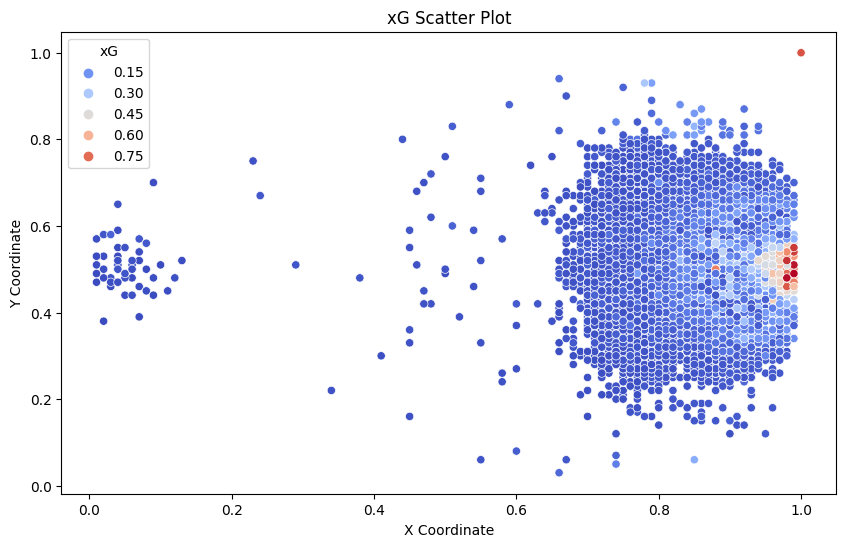

In [334]:
# Scatter plot of xG values w.r.t to X and Y coordinates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['X_coord'], y=X_test['Y_coord'], hue=hyper_preds_xgb, palette='coolwarm')
plt.title("xG Scatter Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="xG")
plt.show()


In [419]:
print("xG Boost Model Evaluation metrics")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_pred)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score :", brier_score)

report_xgb1 = classification_report(y_test, y_preds)
print(report_xgb1)



print("xG Boost HYPER PARAMETER MODEL EVALUATION METRICS")

accuracy = accuracy_score(y_test, hyper_xgb_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_xgb_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_xgb_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, hyper_xgb_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_xgb_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_xgb_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_xgb)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_xgb_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_pred)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_preds_xgb)
print("Brier Score :", brier_score)	

report_xgb2 = classification_report(y_test, hyper_xgb_preds)
print(report_xgb2)

xG Boost Model Evaluation metrics
Accuracy: 0.90
Precision: 0.62
Recall: 0.18
ROC AUC: 0.59
Mean Squared Error: 0.10
F1 Score: 0.284037558685446
Log Loss value : 0.2790953756049287
Confusion Matrix:
 [[10901   150]
 [ 1070   242]]
Brier Score : 0.07948406361549668
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11051
           1       0.62      0.18      0.28      1312

    accuracy                           0.90     12363
   macro avg       0.76      0.59      0.62     12363
weighted avg       0.88      0.90      0.88     12363

xG Boost HYPER PARAMETER MODEL EVALUATION METRICS
Accuracy: 0.90
Precision: 0.70
Recall: 0.16
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.2613003095975232
Log Loss value : 0.26957356974917773
Confusion Matrix:
 [[10959    92]
 [ 1101   211]]
Brier Score : 0.0774427711670322
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11051
           1     

In [426]:
#xG Function xG BOOST

def calculate_xG(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = xgb_model.predict_proba(new_data)[0, 1]  # Probability of scoring a goal
    #xG_probability = xgb_s.predict_proba(new_data)[0, 1]
    #xg_prob = xgb_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_xgb_model.predict_proba(scaled_features)[:, 1]
    #new_data['New xG']=xG_probability
    new_data['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data
    #return xG_probability, new_data


position_x = 0.88  # Replace with the actual X-coordinate
position_y = 0.50  # Replace with the actual Y-coordinate
Y_coord_angle = 1.00
is_penalty = 1   # Replace with 1 if it's a penalty, or 0 if it's not
is_header = 0    # Replace with 1 if it's a header, or 0 if it's not
is_home = 1
is_OpenPlay = 1
is_DirectFreekick = 0
is_FromCorner = 0
is_SetPiece = 0
player_name = "lionel messi"

new_xG_data = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]



# def player_attributes(player_name):
#     for p in parameter_sets:
#         p.append(data.loc[data['Player name'] == player_name, 'overall'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'value_eur'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'shooting'].values[0])
    

# new_xG_data = []

for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data=new_xG_data.append(new_data)

print(new_xG_data)

messi_xG_data = new_xG_data



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

In [427]:
#xG Function xG BOOST

def calculate_xG(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = xgb_model.predict_proba(new_data)[0, 1]  # Probability of scoring a goal
    #xG_probability = xgb_s.predict_proba(new_data)[0, 1]
    #xg_prob = xgb_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_xgb_model.predict_proba(scaled_features)[:, 1]
    #new_data['New xG']=xG_probability
    new_data['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data
    #return xG_probability, new_data


position_x = 0.88  # Replace with the actual X-coordinate
position_y = 0.50  # Replace with the actual Y-coordinate
Y_coord_angle = 1.00
is_penalty = 1   # Replace with 1 if it's a penalty, or 0 if it's not
is_header = 0    # Replace with 1 if it's a header, or 0 if it's not
is_home = 1
is_OpenPlay = 1
is_DirectFreekick = 0
is_FromCorner = 0
is_SetPiece = 0
player_name = "vincent kompany"

new_xG_data2 = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]



# def player_attributes(player_name):
#     for p in parameter_sets:
#         p.append(data.loc[data['Player name'] == player_name, 'overall'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'value_eur'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'shooting'].values[0])
    

# new_xG_data = []

for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data2=new_xG_data2.append(new_data)

print(new_xG_data2)

kompany_xG_data = new_xG_data2



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

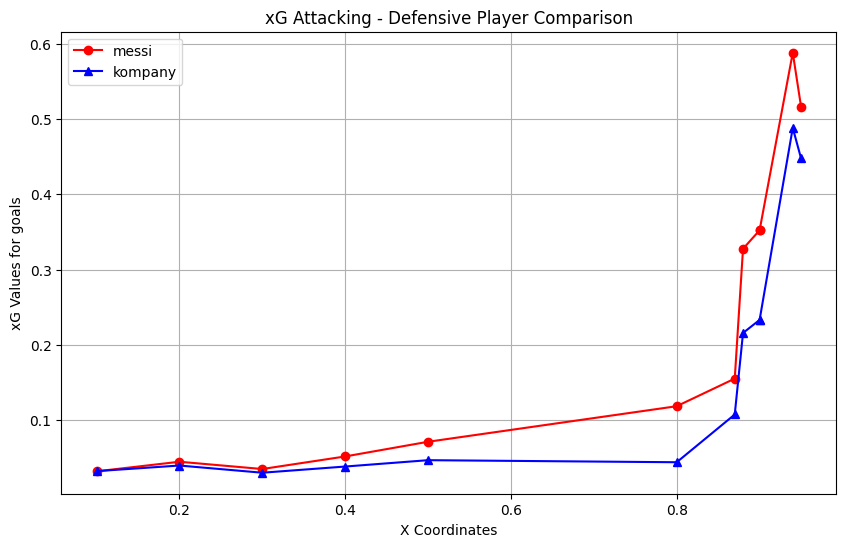

In [429]:
# Comparison of xG values of a highly rated offensive player Messi to defensive player Kompany

# Creating line plots
messi_xG_data = messi_xG_data.sort_values(by=["X_coord", "Y_coord"])
kompany_xG_data = kompany_xG_data.sort_values(by=["X_coord", "Y_coord"])
plt.figure(figsize=(10, 6))
plt.plot(messi_xG_data['X_coord'], messi_xG_data['New xG'], label='messi', color='red', marker='o')
plt.plot(kompany_xG_data['X_coord'], kompany_xG_data['New xG'], label='kompany', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('xG Attacking - Defensive Player Comparison')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

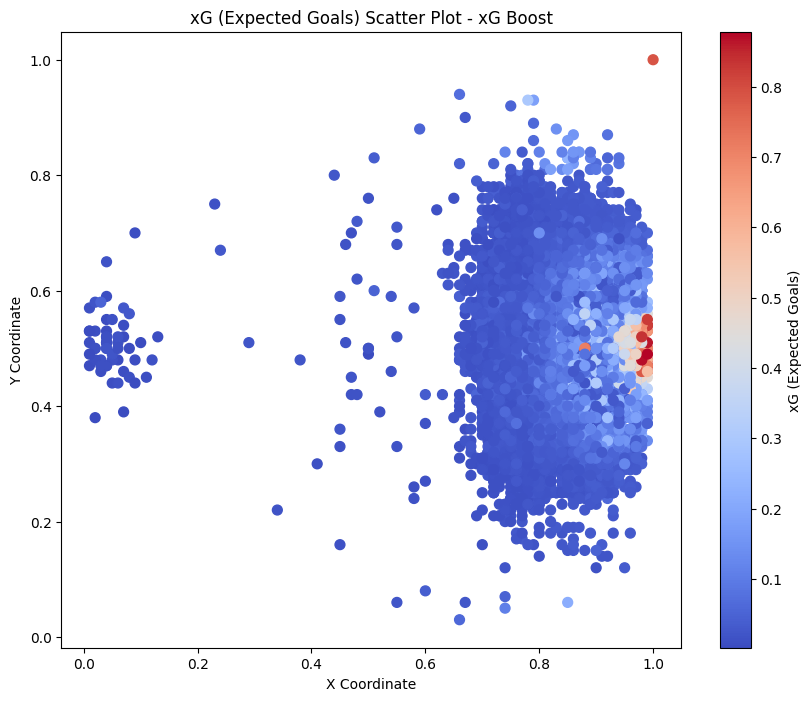

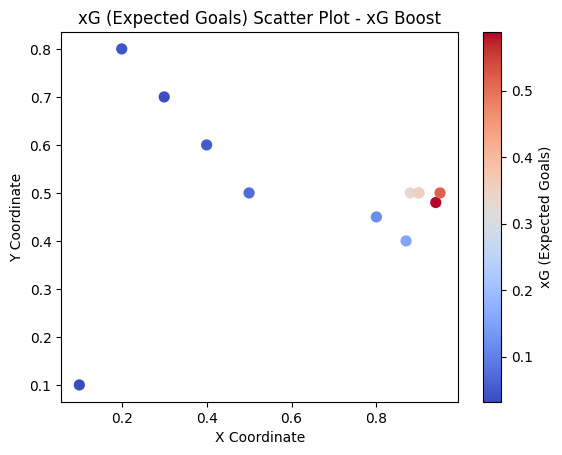

In [337]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - xG Boost')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - xG Boost')
plt.show()


In [338]:
# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Applying undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [339]:
#LOGISTIC REGRESSION 
logreg_model = LogisticRegression(random_state=42)
logreg_model_s = LogisticRegression(random_state=42)

logreg_model.fit(X_train, y_train)
#logreg_model_s.fit(X_train_resampled, y_train_resampled)
logreg_model_s.fit(X_train_scaled, y_train)
#logreg_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
xG_train = logreg_model.predict_proba(X_train)[:, 1]
xG_test = logreg_model.predict_proba(X_test)[:, 1]
y_pred = logreg_model.predict(X_test)



#SCALING
# xG_train = logreg_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = logreg_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = logreg_model_s.predict(X_test_scaled)
#y_preds = logreg_model_s.predict(X_test_scaled)

#SCALING RESAMPLED
# xG_train = logreg_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = logreg_model_s.predict_proba(X_test)[:, 1]
#y_preds = logreg_model_s.predict(X_test)
y_preds = logreg_model_s.predict(X_test_scaled)
y_pred_proba = logreg_model_s.predict_proba(X_test)[:, 1]

# Combinining xG values for the entire dataset
#xG_all = logreg_model.predict_proba(features)[:, 1]
#xG_all = logreg_model_s.predict_proba(features)[:, 1]
xG_all = logreg_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#data['xG_calc_LR'] = xG_all

print("Logistic Regression")

Logistic Regression


In [340]:
# Hyperparameter tuning using GridSearchCV
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search_LR = GridSearchCV(logreg_model_s, param_grid_LR, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_LR.fit(X_train_scaled, y_train)

best_params_LR = grid_search_LR.best_params_
print("Best parameters:", best_params_LR)

# Training Logistic Regression model with the best parameters
# final_logreg_model = LogisticRegression(**best_params, random_state=42)
final_logreg_model = LogisticRegression(**best_params_LR,solver='lbfgs', max_iter=1000,random_state=42)
final_logreg_model.fit(X_train_scaled, y_train)

print("Trained on best parameters")


# Predicting xG values of scaled test set
hyper_preds_logreg = final_logreg_model.predict_proba(X_test_scaled)[:, 1]
hyper_logreg_preds = final_logreg_model.predict(X_test_scaled)

X_test['xG_calc_LR'] = hyper_preds_logreg




Best parameters: {'C': 10, 'penalty': 'l2'}
Trained on best parameters


In [341]:
print("Model Evaluation - LR")
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, y_preds)
#print("R-squared:", r2)



print("HYPER PARAMETER TUNING Model Evaluation - LOGISTIC REGRESSION")
accuracy = accuracy_score(y_test, hyper_logreg_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_logreg_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_logreg_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_logreg_preds)
roc_auc = roc_auc_score(y_test, hyper_logreg_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_logreg_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_logreg_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_logreg)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_logreg_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_logreg_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_logreg_preds)
#print("R-squared:", r2)



Model Evaluation - LR
Accuracy: 0.90
Precision: 0.73
Recall: 0.10
ROC AUC: 0.55
Mean Squared Error: 0.10
F1 Score: 0.17572099262240107
Log Loss value : 32.21858882173692
Confusion Matrix:
 [[11003    48]
 [ 1181   131]]
Brier Score : 0.09940952843161045
HYPER PARAMETER TUNING Model Evaluation - LOGISTIC REGRESSION
Accuracy: 0.90
Precision: 0.73
Recall: 0.11
ROC AUC: 0.55
Mean Squared Error: 0.10
F1 Score: 0.19444444444444445
Log Loss value : 0.27938031907323535
Confusion Matrix:
 [[10998    53]
 [ 1165   147]]
Brier Score : 0.09851977675321524


In [342]:
#LOGISTIC REGRESSION xG Function

def calculate_xG_LR(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_LR = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = logreg_model.predict_proba(new_data_LR)[0, 1]  # Probability of scoring a goal
    #xG_probability = logreg_model_s.predict_proba(new_data_LR)[0, 1]
    #xg_prob = logreg_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_logreg_model.predict_proba(scaled_features)[:, 1]
    #new_data_LR['New xG']=xG_probability
    new_data_LR['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_LR
    #return xG_probability, new_data_LR



new_xG_data_LR  = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])

player_name = "lionel messi"

#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]





for params in parameter_sets:
    xG_probability, new_data_LR = calculate_xG_LR(*params)
    new_xG_data_LR=new_xG_data_LR.append(new_data_LR)

print(new_xG_data_LR)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

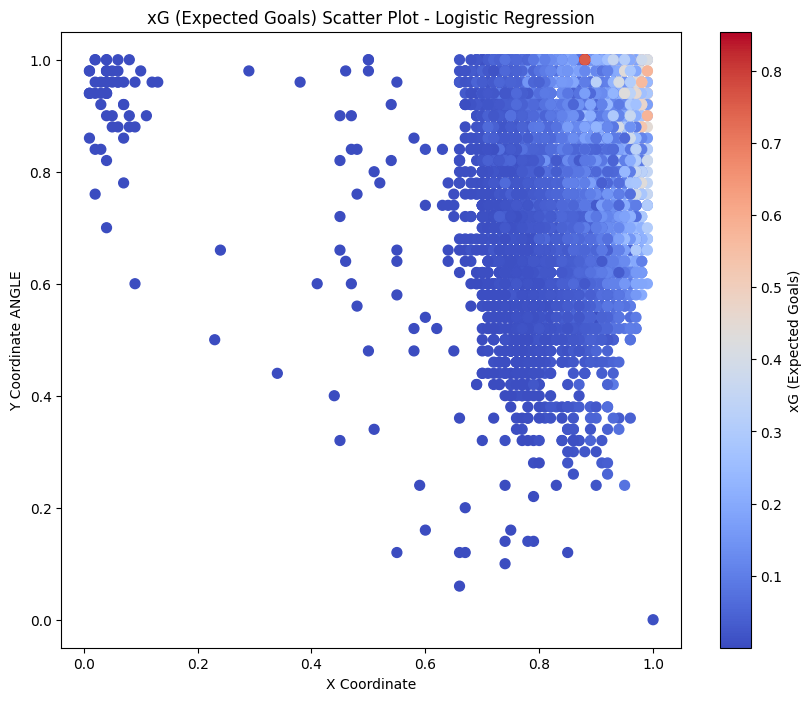

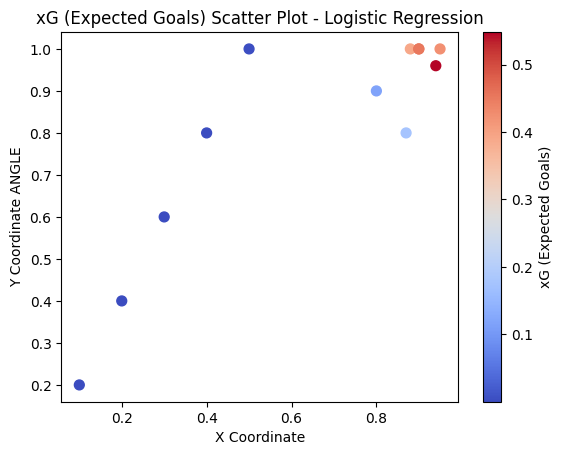

In [343]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord_angle'], c=data['xG_calc_LR'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord_angle'], c=X_test['xG_calc_LR'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate ANGLE')
plt.title('xG (Expected Goals) Scatter Plot - Logistic Regression')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord_angle'], c=new_xG_data_LR['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate ANGLE')
plt.title('xG (Expected Goals) Scatter Plot - Logistic Regression')
plt.show()


In [344]:
# Splitting the data into training and testing sets before RANDOM FORESTS regression
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Applying undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing of the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [345]:
#RANDOM FORESTS REGRESSION 

random_forest_model = RandomForestRegressor(n_estimators=100,random_state=42)
random_forest_model_s = RandomForestRegressor(n_estimators=100,random_state=42)


#Traning
random_forest_model.fit(X_train, y_train)
#random_forest_model_s.fit(X_train_resampled, y_train_resampled)
random_forest_model_s.fit(X_train_scaled, y_train)
#random_forest_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
#xG_train = random_forest_model.predict_proba(X_train)[:, 1]
#xG_test = random_forest_model.predict_proba(X_test)[:, 1]
y_pred = random_forest_model.predict(X_test)


#SCALING
# xG_train = random_forest_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = random_forest_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = random_forest_model_s.predict(X_test_scaled)
#y_preds = random_forest_model_s.predict(X_test_scaled)


#SCALING RESAMPLED
# xG_train = random_forest_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = random_forest_model_s.predict_proba(X_test)[:, 1]
y_preds = random_forest_model_s.predict(X_test_scaled)
#y_preds = random_forest_model_s.predict_proba(X_test_scaled)[:, 1]

# Combinining xG values for the entire dataset
# xG_all = random_forest_model_s.predict_proba(features)[:, 1]
#xG_all = random_forest_model_s.predict_proba(features)[:, 1]
#xG_all = random_forest_model.predict(features)
#xG_all = random_forest_model_s.predict(X_data_scaled)  # Directly use predict_proba on the scaled features
#xG_all = random_forest_model_s.predict(X_data_scaled)
#xG_all = random_forest_model_s.predict(X_test_scaled)
xG_all = y_preds
#data['xG_calc_RFR'] = xG_all
# X_test['xG_calc_RFR'] = xG_all

print("Random forests Regression")

Random forests Regression


In [346]:
# Definining hyperparameters 
# param_grid_random_forest= {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


param_grid_random_forest= {
    'n_estimators': [300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Hyperparameter tuning using GridSearchCV
grid_search_random_forest = GridSearchCV(random_forest_model_s, param_grid_random_forest, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_random_forest.fit(X_train_scaled, y_train)

# Getting the best Random Forests model
best_random_forest_model = grid_search_random_forest.best_estimator_
#hyper_preds_random_forest = best_random_forest_model.predict_proba(X_test_scaled)[:, 1]
hyper_random_forest_preds = best_random_forest_model.predict(X_test_scaled)


# Printing best parameters
print("Best Parameters:", grid_search_random_forest.best_params_)
print("Best Score:", grid_search_random_forest.best_score_)
#X_test['xG_calc_random_forest'] = hyper_preds_random_forest
X_test['xG_calc_RFR'] = hyper_random_forest_preds


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7948304433813135


In [347]:
print("Model Evaluation - RANDOM FORESTS REGRESSION")

y_pred_binary = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred_binary)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred_binary)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)




print("RANDOM FORESTS REGRESSION Hyper Parameter Tuning Model Evaluation")

hyper_random_forest_preds = np.where(hyper_random_forest_preds > 0.5, 1, 0)

accuracy = accuracy_score(y_test, hyper_random_forest_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_random_forest_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_random_forest_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_random_forest_preds)
roc_auc = roc_auc_score(y_test, hyper_random_forest_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_random_forest_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_random_forest_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, hyper_random_forest_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_random_forest_preds)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, hyper_random_forest_preds)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_random_forest_preds)
print("Brier Score :", brier_score)

Model Evaluation - RANDOM FORESTS REGRESSION
Accuracy: 0.90
Precision: 0.55
Recall: 0.18
ROC AUC: 0.75
Mean Squared Error: 0.09
F1 Score: 0.2741290691033695
Log Loss value : 0.420905262534176
Confusion Matrix:
 [[10852   199]
 [ 1072   240]]
R-squared: 0.09218939074576848
Brier Score : 0.08612715898707689
RANDOM FORESTS REGRESSION Hyper Parameter Tuning Model Evaluation
Accuracy: 0.90
Precision: 0.66
Recall: 0.15
ROC AUC: 0.57
Mean Squared Error: 0.10
F1 Score: 0.2506172839506173
Confusion Matrix:
 [[10946   105]
 [ 1109   203]]
R-squared: -0.035159189875764385
Brier Score : 0.09819623068834425


In [348]:
#RANDOM FORESTS REGRESSOR xG Function

def calculate_xG_RFR(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_RFR = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = random_forest_model.predict(new_data_RFR)  # Probability of scoring a goal
    #xG_probability = random_forest_model_s.predict(new_data_RFR)
    #xg_prob = random_forest_model_s.predict(scaled_features)
    xg_prob = best_random_forest_model.predict(scaled_features)
    #xG_probability = random_forest_model_s.predict_proba(new_data_RFR)[0, 1]
    #xg_prob = random_forest_model_s.predict_proba(scaled_features)[:, 1]
    #new_data_RFR['New xG']=xG_probability
    new_data_RFR['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_RFR
    #return xG_probability, new_data_RFR



new_xG_data_RFR = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]







for params in parameter_sets:
    xG_probability, new_data_RFR = calculate_xG_RFR(*params)
    new_xG_data_RFR=new_xG_data_RFR.append(new_data_RFR)

print(new_xG_data_RFR)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

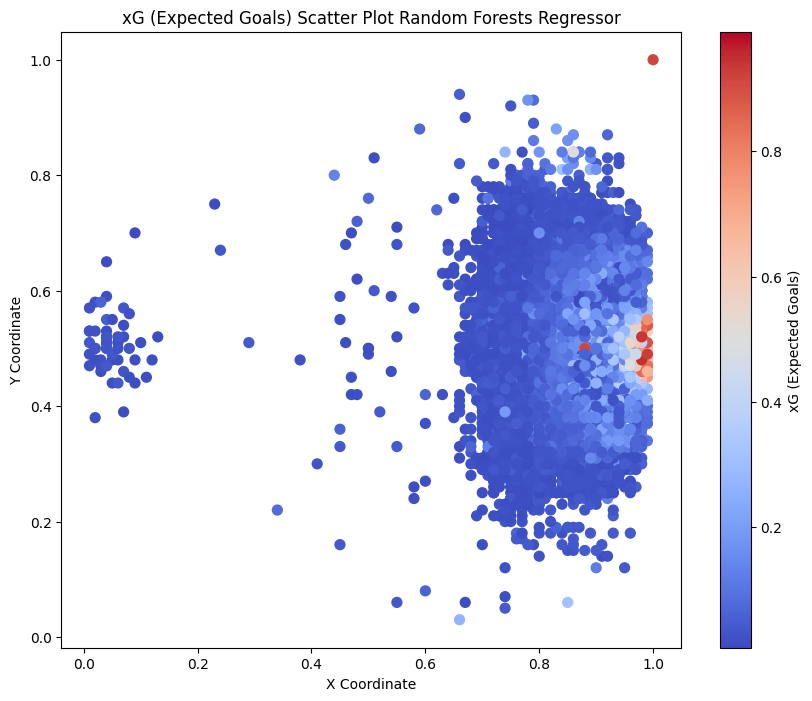

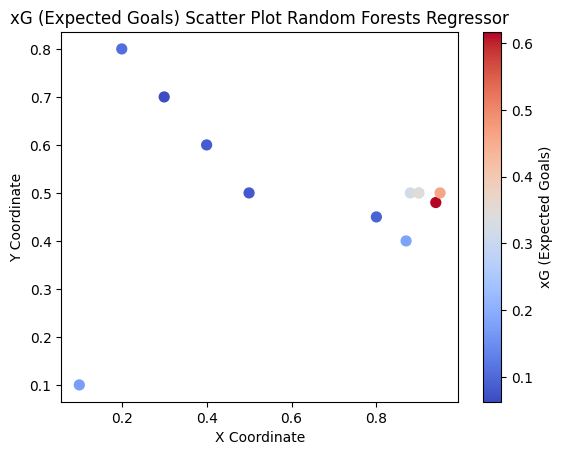

In [349]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_RFR'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_RFR'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Regressor')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_RFR['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Regressor')
plt.show()


In [350]:
# Splitting the data into training and testing sets before RANDOM FORESTS CLASSIFIER
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features) 
print("Feature Scaling")

Sampling
Feature Scaling


In [351]:
#RANDOM FORESTS CLASSIFIER

rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model_s = RandomForestClassifier(n_estimators=100,random_state=42)

rf_model.fit(X_train, y_train)
#rf_model_s.fit(X_train_resampled, y_train_resampled)
# rf_model_s.fit(X_train_scaled, y_train)
rf_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
xG_train = rf_model.predict_proba(X_train)[:, 1]
xG_test = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)



#SCALING
# xG_train = rf_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = rf_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = rf_model_s.predict(X_test_scaled)
#y_preds = rf_model_s.predict(X_test_scaled)

#SCALING RESAMPLED
# xG_train = rf_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = rf_model_s.predict_proba(X_test)[:, 1]
#y_preds = rf_model_s.predict(X_test)
y_preds = rf_model_s.predict(X_test_scaled)

# Combinining xG values for the entire dataset
#xG_all = rf_model_s.predict_proba(features)[:, 1]
#xG_all = rf_model.predict_proba(features)[:, 1]
#xG_all = rf_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
xG_all = rf_model_s.predict_proba(X_test_scaled)[:, 1]
# data['xG_calc_RFC'] = xG_all
# X_test['xG_calc_RFC'] = xG_all

print("Random Forests Classifier")

Random Forests Classifier


In [352]:
# Defining hyperparameters 
# param_grid_rf= {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


param_grid_rf= {
    'n_estimators': [300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Performing hyperparameter tuning using GridSearchCV
grid_search_rf = GridSearchCV(rf_model_s, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_scaled_resampled, y_train_resampled)

# Getting the best Random Forests model
best_rf_model = grid_search_rf.best_estimator_
hyper_preds_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]
hyper_rf_preds = best_rf_model.predict(X_test_scaled)


# Printing best parameters and score from hyperparameter tuning
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)
X_test['xG_calc_RFC'] = hyper_preds_rf


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9772563562107002


In [353]:
print("Model Evaluation - RANDOM FORESTS CLASSIFIER")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, y_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
#r2 = r2_score(y_test, y_preds)
#print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)



print("RANDOM FORESTS CLASSIFIER Hyper Parameter tuned Model Evaluation")

accuracy = accuracy_score(y_test, hyper_rf_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_rf_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_rf_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_rf_preds)
roc_auc = roc_auc_score(y_test, hyper_rf_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_rf_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_rf_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, hyper_rf_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_rf_preds)
print("Confusion Matrix:\n", conf_matrix)
#r2 = r2_score(y_test, hyper_rf_preds)
#print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_rf_preds)
print("Brier Score :", brier_score)

Model Evaluation - RANDOM FORESTS CLASSIFIER
Accuracy: 0.88
Precision: 0.41
Recall: 0.26
ROC AUC: 0.61
Mean Squared Error: 0.12
F1 Score: 0.31668237511781344
Confusion Matrix:
 [[10577   474]
 [  976   336]]
Brier Score : 0.11728544851573243
RANDOM FORESTS CLASSIFIER Hyper Parameter tuned Model Evaluation
Accuracy: 0.88
Precision: 0.42
Recall: 0.26
ROC AUC: 0.61
Mean Squared Error: 0.12
F1 Score: 0.32026452527161076
Confusion Matrix:
 [[10585   466]
 [  973   339]]
Brier Score : 0.11639569683733722


In [354]:
#RANDOM FORESTS CLASSIFIER xG Function

def calculate_xG_RFC(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_RFC = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = rf_model_s.predict_proba(new_data_RFC)[0, 1]
    #xg_prob = rf_model_s.predict(scaled_features)
    #xG_probability = rf_model.predict_proba(new_data_RFC)[0, 1]
    #xg_prob = rf_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = best_rf_model.predict_proba(scaled_features)[:, 1]
    #new_data_RFC['New xG']=xG_probability
    new_data_RFC['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_RFC
    #return xG_probability, new_data_RFC



new_xG_data_RFC = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]







for params in parameter_sets:
    xG_probability, new_data_RFC = calculate_xG_RFC(*params)
    new_xG_data_RFC=new_xG_data_RFC.append(new_data_RFC)

print(new_xG_data_RFC)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

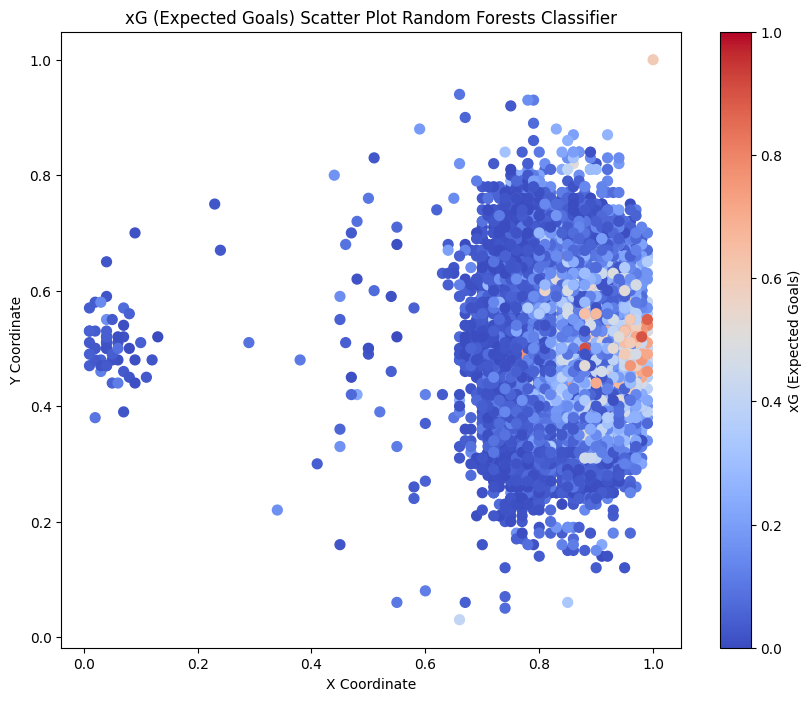

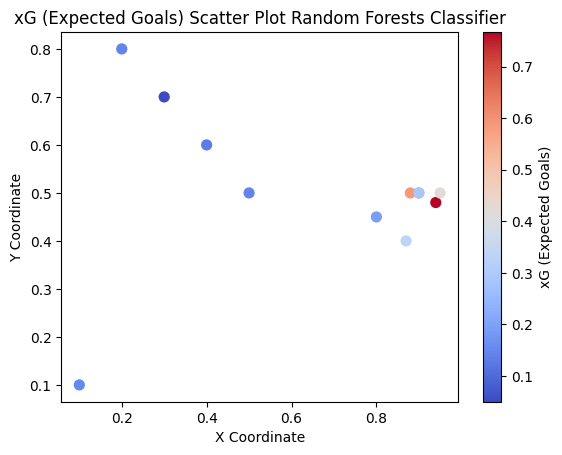

In [355]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_RFC'], cmap='coolwarm', s=50
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_RFC'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Classifier')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_RFC['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Classifier')
plt.show()


In [356]:
# Splitting the data into training and testing sets before ANN MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Applying undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [362]:
# ARTIFICIAL NEURAL NETWORK

# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test)


#---------------------------------------------------------------------------------------------------
#SAMPLED


# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test)


#------------------------------------------------------------------------------------------------------
#SCALED


# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
#xG_all = ann_model.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test_scaled)


#---------------------------------------------------------------------------------------------------------
#SCALED SAMPLED



ann_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled_resampled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann_model.fit(X_train_scaled_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=1)

#xG_all = ann_model.predict(features)
#xG_all = ann_model.predict(X_data_scaled)
xG_all = ann_model.predict(X_test_scaled)
#xG_all = ann_model.predict_proba(X_data_scaled)[:, 1]  
# data['xG_calc_ANN'] = xG_all
X_test['xG_calc_ANN'] = xG_all

# y_pred_proba = ann_model.predict_proba(X_test_scaled)[:, 1]  
y_pred = ann_model.predict(X_test_scaled)


print("ARTIFICIAL NEURAL NETWORK")

Epoch 1/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4505 - accuracy: 0.7806
Epoch 2/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4180 - accuracy: 0.8006
Epoch 3/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4130 - accuracy: 0.8030
Epoch 4/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4081 - accuracy: 0.8083
Epoch 5/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4029 - accuracy: 0.8115
Epoch 6/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4007 - accuracy: 0.8120
Epoch 7/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3955 - accuracy: 0.8159
Epoch 8/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3935 - accuracy: 0.8178
Epoch 9/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3923 - accuracy: 0.8187
Epoch 10/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.389

In [408]:
# Initializing the ANN model
ann_model_s = MLPClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid_ANN = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 30, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'logistic']
}



grid_search_ANN = GridSearchCV(ann_model_s, param_grid_ANN, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_ANN.fit(X_train_scaled_resampled, y_train_resampled)

# Getting the best parameters and best model
best_params_ANN = grid_search_ANN.best_params_
best_ann_model = grid_search_ANN.best_estimator_

# Predicting xG probabilities
hyper_preds_ann = best_ann_model.predict_proba(X_test_scaled)[:, 1]
hyper_ann_preds = best_ann_model.predict(X_test_scaled)

print(best_params_ANN)

#X_test['xG_calc_ANN'] = hyper_preds_ann

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}


In [364]:
print("Model Evaluation - ARTIFICIAL NEURAL NETWORK")

y_pred_binary = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred_binary)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred_binary)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)



print("ANN MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_ann_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_ann_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_ann_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_ann_preds)
roc_auc = roc_auc_score(y_test, hyper_ann_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_ann_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_ann_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_ann)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_ann_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_ann_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_ann_preds)
#print("R-squared:", r2)


Model Evaluation - ARTIFICIAL NEURAL NETWORK
Accuracy: 0.81
Precision: 0.29
Recall: 0.53
ROC AUC: 0.77
Mean Squared Error: 0.13
F1 Score: 0.3768817204301075
Log Loss value : 0.40687982834765923
Confusion Matrix:
 [[9344 1707]
 [ 611  701]]
R-squared: -0.3642740139294287
ANN MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.80
Precision: 0.28
Recall: 0.57
ROC AUC: 0.70
Mean Squared Error: 0.20
F1 Score: 0.3793710691823899
Log Loss value : 0.42469349256259464
Confusion Matrix:
 [[9142 1909]
 [ 558  754]]
Brier Score : 0.19954703550918063


In [365]:
#ARTIFICIAL NEURAL NETWORK xG Function

def calculate_xG_ANN(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_ANN = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = ann_model.predict(new_data_ANN)  # Probability of scoring a goal
    #xG_probability = ann_model.predict_proba(new_data_ANN)[0, 1]
    xg_prob = ann_model.predict(scaled_features)
    #xg_prob = best_ann_model.predict_proba(scaled_features)[:, 1]
    #new_data_ANN['New xG']=xG_probability
    new_data_ANN['New xG']=xg_prob
    return xg_prob,new_data_ANN
    #return xG_probability, new_data_ANN



new_xG_data_ANN = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






for params in parameter_sets:
    xG_probability, new_data_ANN = calculate_xG_ANN(*params)
    new_xG_data_ANN=new_xG_data_ANN.append(new_data_ANN)

print(new_xG_data_ANN)



1/1 [==============================] - 0s 43ms/step
   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10     

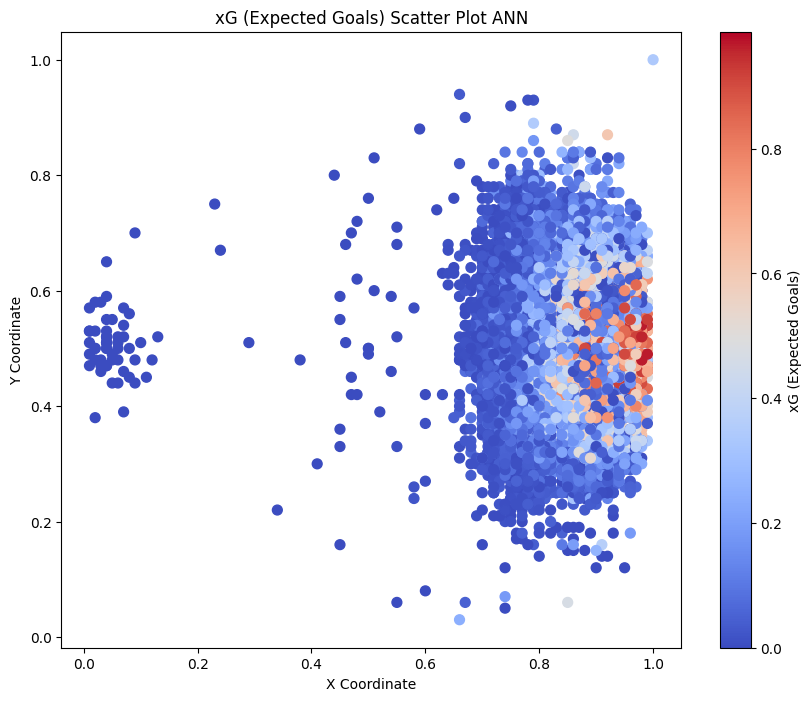

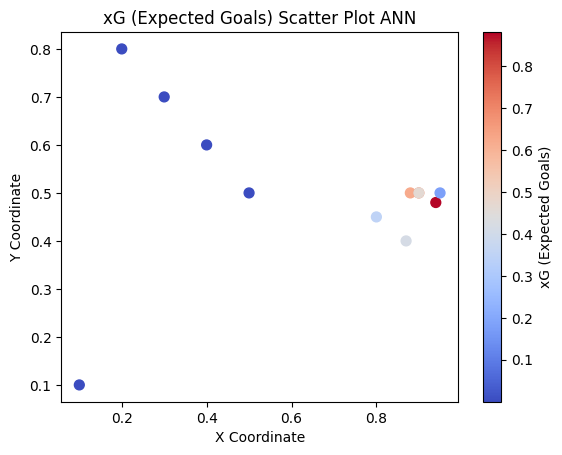

In [366]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_ANN'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_ANN'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ANN')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_ANN['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ANN')
plt.show()


In [367]:
# Splitting the data into training and testing sets before LGB MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [368]:
#LIGHT GRADIENT BOOSTING MODEL LIGHTGBM

# Buildig LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model_s = lgb.LGBMClassifier(random_state=42)


lgb_model.fit(X_train, y_train)
#lgb_model_s.fit(X_train_resampled,y_train_resampled)
lgb_model_s.fit(X_train_scaled, y_train)
#lgb_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = lgb_model.predict(X_test)
#y_preds = lgb_model_s.predict(X_test)
y_preds = lgb_model_s.predict(X_test_scaled)



# Combinining xG values for the entire dataset
#xG_all = lgb_model.predict_proba(features)[:, 1]
#xG_all = lgb_model_s.predict_proba(features)[:, 1]
#xG_all = lgb_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#xG_all = lgb_model_s.predict(X_data_scaled)
# xG_all = lgb_model_s.predict_proba(X_data_scaled)[:, 1]
y_pred_proba = lgb_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all = lgb_model_s.predict_proba(X_test_scaled)[:, 1]
# data['xG_calc_LGB'] = xG_all
X_test['xG_calc_LGB'] = xG_all


print("LIGHT GRADIENT BOOSTING MODEL Prediction")

[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106087 -> initscore=-2.131349
[LightGBM] [Info] Start training from score -2.131349
[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info

In [369]:
#LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING


# Hyperparameter tuning
param_grid_LGM = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    # Add more hyperparameters to tune
}

# Initializing GridSearchCV
grid_search_LGM = GridSearchCV(lgb_model_s, param_grid_LGM, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_LGM.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search_LGM.best_params_)

# Initializing  XGBoost model 
best_params_LGM = grid_search_LGM.best_params_
final_lgb_model = lgb.LGBMClassifier(**best_params_LGM, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_lgb_model.fit(X_train_scaled, y_train)

# Predict xG values
hyper_preds_lgb = final_lgb_model.predict_proba(X_test_scaled)[:, 1]
hyper_lgb_preds = final_lgb_model.predict(X_test_scaled)

X_test['xG_calc_LGB'] = hyper_preds_lgb



xG_all = final_lgb_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LGB'] = xG_all

print("xG values Copied into dataframe")


[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106087 -> initscore=-2.131349
[LightGBM] [Info] Start training from score -2.131349
Best Parameters: {'learning_rate': 0.1, 'num_leaves': 31}
[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the trai

In [370]:
print("Model Evaluation metrics - LIGHTGBM ")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)


print("LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_lgb_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_lgb_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_lgb_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_lgb_preds)
roc_auc = roc_auc_score(y_test, hyper_lgb_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_lgb_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_lgb_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_lgb)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_lgb_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_lgb_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_lgb_preds)
#print("R-squared:", r2)


Model Evaluation metrics - LIGHTGBM 
Accuracy: 0.90
Precision: 0.67
Recall: 0.17
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.2770719903206291
Log Loss value : 0.2705264587307067
Confusion Matrix:
 [[10939   112]
 [ 1083   229]]
Brier Score : 0.09665938688020707
LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.90
Precision: 0.67
Recall: 0.17
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.2770719903206291
Log Loss value : 0.2705264587307067
Confusion Matrix:
 [[10939   112]
 [ 1083   229]]
Brier Score : 0.09665938688020707


In [371]:
#LIGHTGBM xG Function

def calculate_xG_LGM(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_LGM = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = lgb_model.predict_proba(new_data_LGM)[0, 1]  # Probability of scoring a goal
    #xG_probability = lgb_model_s.predict_proba(new_data_LGM)[0, 1]
    #xg_prob = lgb_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_lgb_model.predict_proba(scaled_features)[:, 1]
    #new_data_LGM['New xG']=xG_probability
    new_data_LGM['New xG']=xg_prob
    return xg_prob[0],new_data_LGM
    #return xG_probability, new_data_LGM



new_xG_data_LGM = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






# new_xG_data_LGM = []

for params in parameter_sets:
    xG_probability, new_data_LGM = calculate_xG_LGM(*params)
    new_xG_data_LGM=new_xG_data_LGM.append(new_data_LGM)

print(new_xG_data_LGM)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

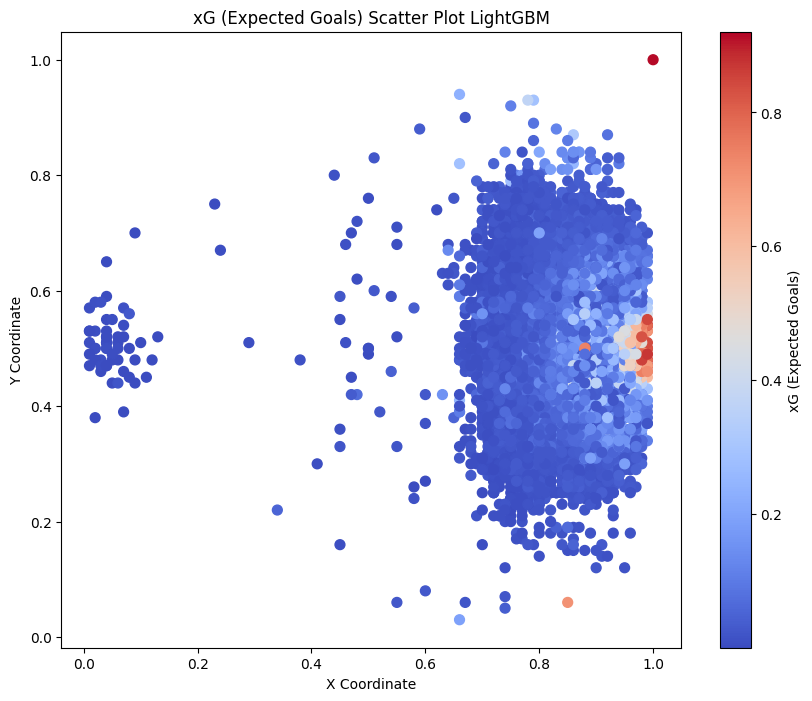

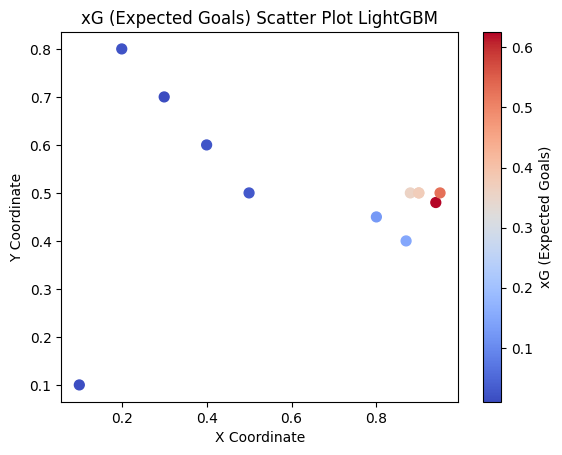

In [372]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_LGM'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_LGB'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LightGBM')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_LGM['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LightGBM')
plt.show()


In [373]:
# Splitting the data into training and testing sets before ADABOOST  MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Applying undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [374]:
#ADABOOST MODEL

# Building ADABOOST model
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model_s = AdaBoostClassifier(random_state=42)


adaboost_model.fit(X_train, y_train)
#adaboost_model_s.fit(X_train_resampled,y_train_resampled)
#adaboost_model_s.fit(X_train_scaled, y_train)
adaboost_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = adaboost_model.predict(X_test)
#y_preds = adaboost_model_s.predict(X_test)
y_preds = adaboost_model_s.predict(X_test_scaled)


# Combinining xG values for the entire dataset
#xG_all = adaboost_model.predict_proba(features)[:, 1]
#xG_all = adaboost_model_s.predict_proba(features)[:, 1]
#xG_all = adaboost_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
y_pred_proba = adaboost_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all =  adaboost_model_s.predict(X_test_scaled)
#X_test['xG_calc_ADABOOST'] = xG_all

#data['xG_calc_ADABOOST'] = xG_all

print("ADABOOST MODEL Prediction")

ADABOOST MODEL Prediction


In [375]:
#ADABOOST MODEL HYPER PARAMETER TUNING

# Hyperparameter tuning
# param_grid_ADA = {
#     'n_estimators': [50, 100, 200,300,500],
#     'learning_rate': [0.01, 0.1, 0.2,0.3,0.5],
#     # Add more hyperparameters to tune
# }

param_grid_ADA = {
    'n_estimators': [500],
    'learning_rate': [0.5],
    # Add more hyperparameters to tune
}

# Initializing GridSearchCV
grid_search_ADA = GridSearchCV(adaboost_model_s, param_grid_ADA, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_ADA.fit(X_train_scaled_resampled, y_train_resampled)

# Printing best parameters
print("Best Parameters:", grid_search_ADA.best_params_)

# Initializing the XGBoost model with best parameters
best_params_ADA = grid_search_ADA.best_params_
final_adaboost_model = AdaBoostClassifier(**best_params_ADA, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_adaboost_model.fit(X_train_scaled_resampled, y_train_resampled)

# Predicting xG values on the scaled test set
hyper_preds_adaboost = final_adaboost_model.predict_proba(X_test_scaled)[:, 1]
hyper_adaboost_preds = final_adaboost_model.predict(X_test_scaled)

X_test['xG_calc_adaboost'] = hyper_preds_adaboost



Best Parameters: {'learning_rate': 0.5, 'n_estimators': 500}


In [376]:
print("Model Evaluation metrics - ADABOOST Model ")


y_preds = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)





print("ADABOOST MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_adaboost_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_adaboost_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_adaboost_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_adaboost_preds)
roc_auc = roc_auc_score(y_test, hyper_adaboost_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_adaboost_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_adaboost_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_adaboost)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_adaboost_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_adaboost_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_adaboost_preds)
#print("R-squared:", r2)


Model Evaluation metrics - ADABOOST Model 
Accuracy: 0.80
Precision: 0.28
Recall: 0.54
ROC AUC: 0.68
Mean Squared Error: 0.20
F1 Score: 0.36415436415436414
Log Loss value : 0.6803246086270368
Confusion Matrix:
 [[9205 1846]
 [ 609  703]]
Brier Score : 0.19857639731456767
ADABOOST MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.85
Precision: 0.33
Recall: 0.42
ROC AUC: 0.66
Mean Squared Error: 0.15
F1 Score: 0.3674983142279164
Log Loss value : 0.6900217176790011
Confusion Matrix:
 [[9942 1109]
 [ 767  545]]
Brier Score : 0.15174310442449243


In [377]:
#ADABOOST xG Function

def calculate_xG_adaboost(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_adaboost = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = adaboost_model.predict_proba(new_data_adaboost)[0, 1]  # Probability of scoring a goal
    #xG_probability = adaboost_model_s.predict_proba(new_data_adaboost)[0, 1]
    #xg_prob = adaboost_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_adaboost_model.predict_proba(scaled_features)[:, 1]
    #new_data_adaboost['New xG']=xG_probability
    new_data_adaboost['New xG']=xg_prob
    return xg_prob[0],new_data_adaboost
    #return xG_probability, new_data_adaboost



new_xG_data_adaboost  = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






# new_xG_data_adaboost = []

for params in parameter_sets:
    xG_probability, new_data_adaboost = calculate_xG_adaboost(*params)
    new_xG_data_adaboost=new_xG_data_adaboost.append(new_data_adaboost)

print(new_xG_data_adaboost)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

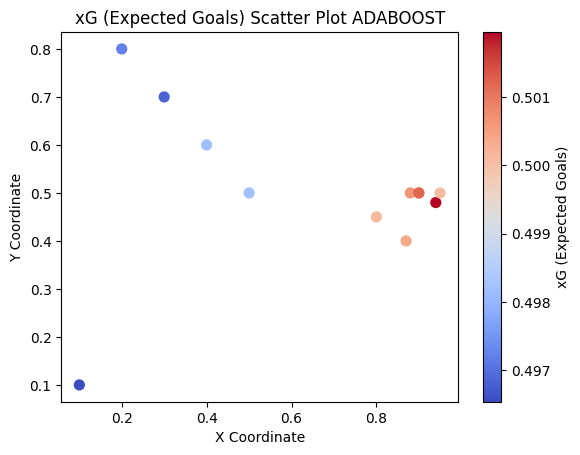

In [378]:
# plt.figure(figsize=(10, 8))
# # plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_ADABOOST'], cmap='coolwarm', s=50)
# plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=hyper_preds_adaboost, cmap='coolwarm', s=50)
# plt.colorbar(label='xG (Expected Goals)')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('xG (Expected Goals) Scatter Plot')
# plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_adaboost['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ADABOOST')
plt.show()


In [379]:
# Splitting  the data into training and testing sets before CATBOOST  MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Applying undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [409]:
#catboost MODEL

# Building catboost model
catboost_model = CatBoostClassifier(random_state=42)
catboost_model_s = CatBoostClassifier(random_state=42)


catboost_model.fit(X_train, y_train)
#catboost_model_s.fit(X_train_resampled,y_train_resampled)
#catboost_model_s.fit(X_train_scaled, y_train)
catboost_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = catboost_model.predict(X_test)
#y_preds = catboost_model_s.predict(X_test)
y_preds = catboost_model_s.predict(X_test_scaled)



# Combinining xG values for the entire dataset
#xG_all = catboost_model.predict_proba(features)[:, 1]
#xG_all = catboost_model_s.predict_proba(features)[:, 1]
y_pred_proba = catboost_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all = catboost_model_s.predict_proba(X_test_scaled)[:, 1] 
#data['xG_calc_catboost'] = xG_all
#X_test['xG_calc_catboost'] = xG_all



print("catboost MODEL Prediction")
print(xG_all)

Learning rate set to 0.054493
0:	learn: 0.6392470	total: 81.4ms	remaining: 1m 21s
1:	learn: 0.5935498	total: 106ms	remaining: 53s
2:	learn: 0.5546379	total: 133ms	remaining: 44.2s
3:	learn: 0.5187963	total: 159ms	remaining: 39.6s
4:	learn: 0.4877771	total: 182ms	remaining: 36.2s
5:	learn: 0.4628161	total: 204ms	remaining: 33.9s
6:	learn: 0.4419568	total: 221ms	remaining: 31.4s
7:	learn: 0.4221638	total: 238ms	remaining: 29.4s
8:	learn: 0.4076184	total: 256ms	remaining: 28.2s
9:	learn: 0.3937311	total: 277ms	remaining: 27.4s
10:	learn: 0.3800343	total: 300ms	remaining: 27s
11:	learn: 0.3688502	total: 321ms	remaining: 26.4s
12:	learn: 0.3594179	total: 342ms	remaining: 25.9s
13:	learn: 0.3505095	total: 361ms	remaining: 25.4s
14:	learn: 0.3419150	total: 385ms	remaining: 25.3s
15:	learn: 0.3344436	total: 409ms	remaining: 25.1s
16:	learn: 0.3276481	total: 431ms	remaining: 24.9s
17:	learn: 0.3214030	total: 453ms	remaining: 24.7s
18:	learn: 0.3161090	total: 471ms	remaining: 24.3s
19:	learn: 0.

In [381]:
#catBOOST MODEL HYPER PARAMETER TUNING

# Hyperparameter tuning
# Define the parameter grid for tuning
param_grid_cat= {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}
# Initialize GridSearchCV
grid_search_cat = GridSearchCV(catboost_model_s, param_grid_cat, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_cat.fit(X_train_scaled_resampled, y_train_resampled)



# Initialize the XGBoost model with best parameters
best_params_cat = grid_search_cat.best_params_
final_catboost_model = CatBoostClassifier(**best_params_cat, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_catboost_model.fit(X_train_scaled_resampled, y_train_resampled)

# Predict xG values on the scaled test set
hyper_preds_catboost = final_catboost_model.predict_proba(X_test_scaled)[:, 1]
hyper_catboost_preds = final_catboost_model.predict(X_test_scaled)

X_test['xG_calc_catboost'] = hyper_preds_catboost

# Print best parameters
print("Best Parameters:", grid_search_cat.best_params_)



0:	learn: 0.6224134	total: 84.4ms	remaining: 25.2s
1:	learn: 0.5828838	total: 152ms	remaining: 22.6s
2:	learn: 0.5534927	total: 205ms	remaining: 20.3s
3:	learn: 0.5316782	total: 248ms	remaining: 18.4s
4:	learn: 0.5144651	total: 296ms	remaining: 17.5s
5:	learn: 0.4847397	total: 353ms	remaining: 17.3s
6:	learn: 0.4674035	total: 406ms	remaining: 17s
7:	learn: 0.4515928	total: 454ms	remaining: 16.6s
8:	learn: 0.4278134	total: 505ms	remaining: 16.3s
9:	learn: 0.4198149	total: 554ms	remaining: 16.1s
10:	learn: 0.4025903	total: 602ms	remaining: 15.8s
11:	learn: 0.3847177	total: 652ms	remaining: 15.7s
12:	learn: 0.3716295	total: 705ms	remaining: 15.6s
13:	learn: 0.3616301	total: 751ms	remaining: 15.3s
14:	learn: 0.3536721	total: 807ms	remaining: 15.3s
15:	learn: 0.3462191	total: 857ms	remaining: 15.2s
16:	learn: 0.3414410	total: 909ms	remaining: 15.1s
17:	learn: 0.3348640	total: 961ms	remaining: 15.1s
18:	learn: 0.3265510	total: 1.01s	remaining: 14.9s
19:	learn: 0.3193792	total: 1.05s	remainin

In [410]:
print("Model Evaluation metrics - CATBOOST Model ")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)



print("catBOOST MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_catboost_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_catboost_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_catboost_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_catboost_preds)
roc_auc = roc_auc_score(y_test, hyper_catboost_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_catboost_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_catboost_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_catboost)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_catboost_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_catboost_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_catboost_preds)
#print("R-squared:", r2)


Model Evaluation metrics - CATBOOST Model 
Accuracy: 0.90
Precision: 0.59
Recall: 0.21
ROC AUC: 0.60
Mean Squared Error: 0.10
F1 Score: 0.3096846846846847
Log Loss value : 0.27781923633497185
Confusion Matrix:
 [[10862   189]
 [ 1037   275]]
Brier Score : 0.09916686888295721
catBOOST MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.90
Precision: 0.60
Recall: 0.21
ROC AUC: 0.60
Mean Squared Error: 0.10
F1 Score: 0.3141891891891892
Log Loss value : 0.27802961350143796
Confusion Matrix:
 [[10866   185]
 [ 1033   279]]
Brier Score : 0.09851977675321524


In [384]:
#catboost xG Function

def calculate_xG_catboost(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_catboost = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = catboost_model.predict_proba(new_data_catboost)[0, 1]  # Probability of scoring a goal
    #xG_probability = catboost_model_s.predict_proba(new_data_catboost)[0, 1]
    #xg_prob = catboost_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_catboost_model.predict_proba(scaled_features)[:, 1]
    #new_data_catboost['New xG']=xG_probability
    new_data_catboost['New xG']=xg_prob
    return xg_prob[0],new_data_catboost
    #return xG_probability, new_data_catboost



new_xG_data_catboost = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]





# new_xG_data_catboost = []

for params in parameter_sets:
    xG_probability, new_data_catboost = calculate_xG_catboost(*params)
    new_xG_data_catboost=new_xG_data_catboost.append(new_data_catboost)

print(new_xG_data_catboost)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

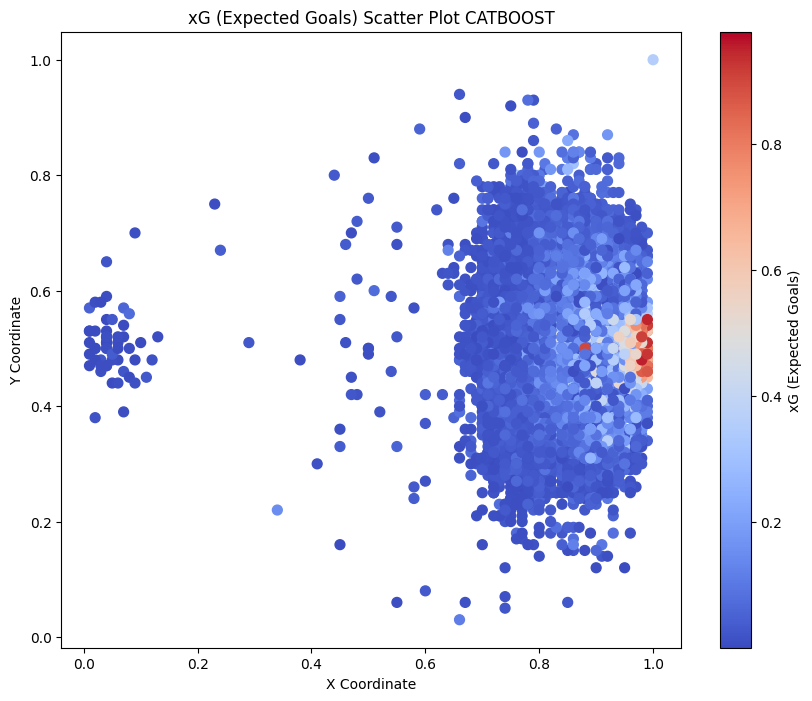

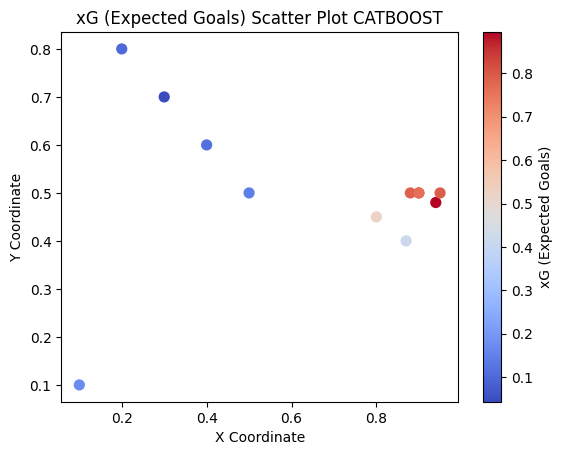

In [385]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_catboost'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_catboost'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot CATBOOST')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_catboost['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot CATBOOST')
plt.show()


In [386]:
# Splitting the data into training and testing sets before LSTM MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Applying oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardizing the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


In [387]:
# LSTM

# Reshaping data for LSTM input (samples, time steps, features)
#features_reshaped = features.values.reshape(features.shape[0], 1, features.shape[1])
features_reshaped = features.values.reshape(features.shape[0], 1, features.shape[1])

# X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# X_train_reshaped = X_train_scaled.values.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# X_test_reshaped = X_test_scaled.values.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Reshaping data for LSTM input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
#-----------------------------------------------------------------------------------------------
# X_train_reshaped = X_train_scaled_resampled.reshape(X_train_scaled_resampled.shape[0], 1, X_train_scaled_resampled.shape[1])
# X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
#--------------------------------------------------------------------------------------------



#SAMPLED
# X_train_resampled_reshaped = X_train_resampled.values.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])




# Building LSTM lstm_model
lstm_model = Sequential()

lstm_model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
# lstm_model.add(LSTM(64, input_shape=(1, X_train_scaled_resampled.shape[1]), activation='relu'))   #SAMPLED

lstm_model.add(Dense(1, activation='sigmoid'))

# Compiling the lstm_model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

#Traning the lstm_model
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))
# lstm_model.fit(X_train_reshaped, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

#SAMPLED
# lstm_model.fit(X_train_resampled_reshaped, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


# Predicting probabilities using the trained lstm_model
y_pred_proba = lstm_model.predict(X_test_reshaped)
# y_pred_proba = lstm_model.predict(X_test_reshaped)    #RESAMPLED

# xG_all_proba = lstm_model.predict(features_reshaped)
print(y_pred_proba)
# Calculate xG values based on predicted probabilities
# xg_values = y_pred_proba.flatten()
# xG_all = xG_all_proba.flatten()
X_test['xG_calc_lstm'] = y_pred_proba
# print(xG_all_proba)
# print("*********************************************************************")
# print(xG_all)


print("LSTM - Long Short Term Memory Model")

Epoch 1/10
1546/1546 [==============================] - 12s 6ms/step - loss: 0.3388 - accuracy: 0.8974 - val_loss: 0.3251 - val_accuracy: 0.8990
Epoch 2/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.3148 - accuracy: 0.9000 - val_loss: 0.3109 - val_accuracy: 0.8990
Epoch 3/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.3057 - accuracy: 0.9000 - val_loss: 0.3016 - val_accuracy: 0.8990
Epoch 4/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2975 - accuracy: 0.9000 - val_loss: 0.2945 - val_accuracy: 0.8990
Epoch 5/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2914 - accuracy: 0.9001 - val_loss: 0.2898 - val_accuracy: 0.8990
Epoch 6/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2872 - accuracy: 0.9002 - val_loss: 0.3035 - val_accuracy: 0.8990
Epoch 7/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2844 - accuracy: 0.9004 - val_loss: 0.2832 - val_accuracy

In [389]:
#MODEL EVALUATION METRICS
y_pred = (y_pred_proba > 0.5).astype(int)

print("Model Evaluation - LSTM ")


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred_proba)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred_proba)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score :", brier_score)







Model Evaluation - LSTM 
Accuracy: 0.90
Precision: 0.74
Recall: 0.09
ROC AUC: 0.79
Mean Squared Error: 0.08
F1 Score: 0.16271186440677965
Log Loss value : 0.27966289410932815
Confusion Matrix:
 [[11008    43]
 [ 1192   120]]
R-squared: 0.15529224010747122
Brier Score : 0.08012981854954718


In [390]:
#LSTM xG Function

def calculate_xG_lstm(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_lstm = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    new_data_lstm_reshaped = new_data_lstm.values.reshape(new_data_lstm.shape[0], 1, new_data_lstm.shape[1])
    #scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home]])
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    reshaped_features = scaled_features.reshape(1, 1, scaled_features.shape[1])
#   xG_probability = lstm_model.predict(new_data_lstm_reshaped)  # Probability of scoring a goal
    xG_probability = lstm_model.predict(reshaped_features)
    #xG_probability = lstm_model_s.predict_proba(new_data_lstm)[0, 1]
    #xg_prob = lstm_model_s.predict_proba(scaled_features)[:, 1]
    new_data_lstm['New xG']=xG_probability
    #new_data_lstm['New xG']=xg_prob
    #return xg_prob[0],new_data_lstm
    return xG_probability, new_data_lstm



new_xG_data_lstm = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]




# new_xG_data_lstm = []

for params in parameter_sets:
    xG_probability, new_data_lstm = calculate_xG_lstm(*params)
    new_xG_data_lstm=new_xG_data_lstm.append(new_data_lstm)

print(new_xG_data_lstm)



1/1 [==============================] - 0s 46ms/step
   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10     

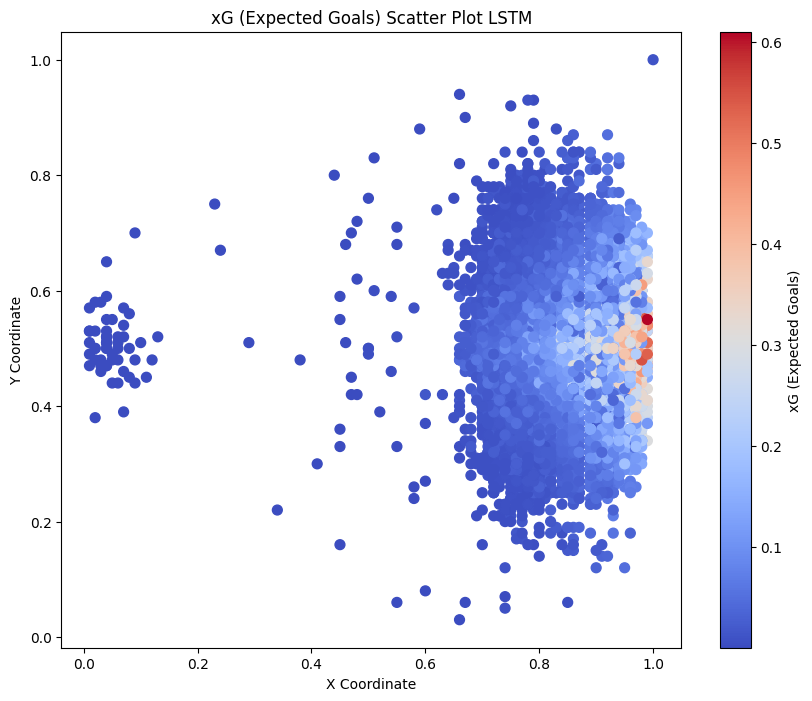

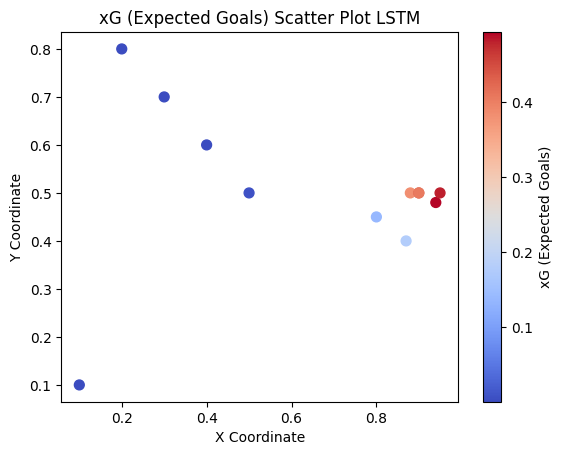

In [391]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_lstm'], cmap='coolwarm', s=50)
X_test = X_test[~((X_test['X_coord'] == 0.88))]
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_lstm'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LSTM')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_lstm['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LSTM')
plt.show()


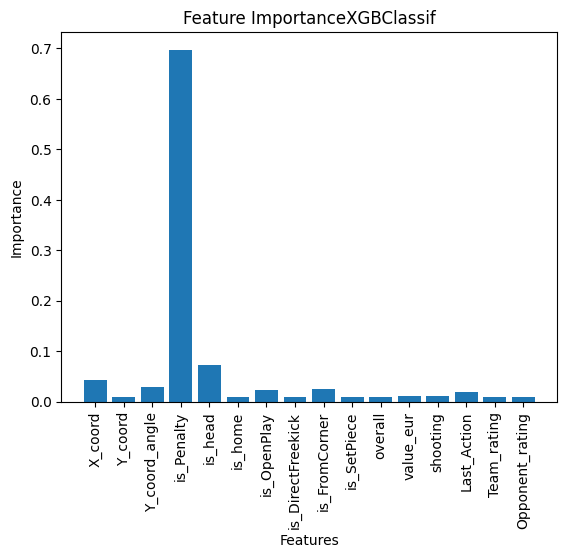

X_coord: 0.042846474796533585
Y_coord: 0.009489663876593113
Y_coord_angle: 0.02889627404510975
is_Penalty: 0.6974268555641174
is_head: 0.0717882439494133
is_home: 0.008652043528854847
is_OpenPlay: 0.02410558983683586
is_DirectFreekick: 0.009383199736475945
is_FromCorner: 0.025851134210824966
is_SetPiece: 0.010346527211368084
overall: 0.010255131870508194
value_eur: 0.01074317004531622
shooting: 0.011253182776272297
Last_Action: 0.019942384213209152
Team_rating: 0.0096462182700634
Opponent_rating: 0.009373907931149006


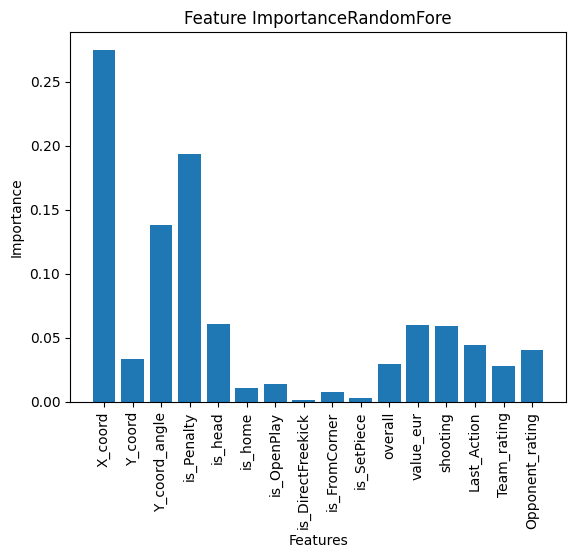

X_coord: 0.27501517880777676
Y_coord: 0.03334884845229412
Y_coord_angle: 0.13815292656013467
is_Penalty: 0.19390674521222614
is_head: 0.06049506086441914
is_home: 0.011075308900505391
is_OpenPlay: 0.014136782959518373
is_DirectFreekick: 0.001574872474808139
is_FromCorner: 0.007706206237091511
is_SetPiece: 0.0026043775629995968
overall: 0.029705251066787643
value_eur: 0.060061386798703216
shooting: 0.058783656111652934
Last_Action: 0.044418423686705226
Team_rating: 0.02828373218980433
Opponent_rating: 0.04073124211457277


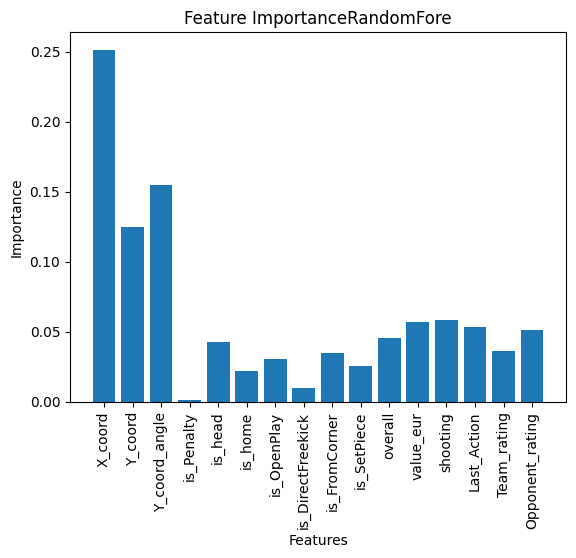

X_coord: 0.2513354751381218
Y_coord: 0.1246367993469432
Y_coord_angle: 0.15493761464596406
is_Penalty: 0.0015808918692628731
is_head: 0.04248696744301918
is_home: 0.021802462950997185
is_OpenPlay: 0.03069057104153696
is_DirectFreekick: 0.010151988531269448
is_FromCorner: 0.03484474382507299
is_SetPiece: 0.02547676977934791
overall: 0.04519704611444215
value_eur: 0.056964372491480564
shooting: 0.058571160034265185
Last_Action: 0.053597663504064356
Team_rating: 0.03618023819756005
Opponent_rating: 0.051545235086652104


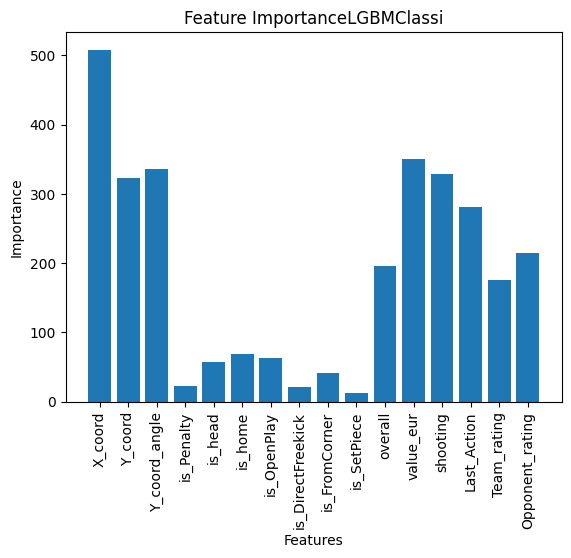

X_coord: 0.16933333333333334
Y_coord: 0.10766666666666666
Y_coord_angle: 0.112
is_Penalty: 0.007333333333333333
is_head: 0.019333333333333334
is_home: 0.023
is_OpenPlay: 0.021
is_DirectFreekick: 0.007
is_FromCorner: 0.013666666666666667
is_SetPiece: 0.004333333333333333
overall: 0.06533333333333333
value_eur: 0.117
shooting: 0.10966666666666666
Last_Action: 0.09366666666666666
Team_rating: 0.058333333333333334
Opponent_rating: 0.07133333333333333


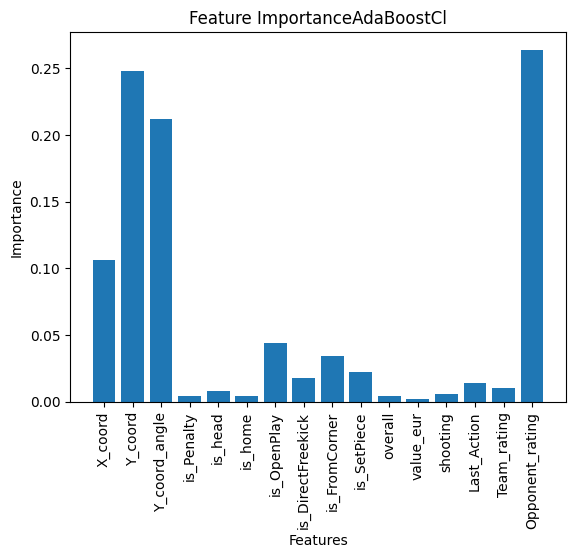

X_coord: 0.106
Y_coord: 0.248
Y_coord_angle: 0.212
is_Penalty: 0.004
is_head: 0.008
is_home: 0.004
is_OpenPlay: 0.044
is_DirectFreekick: 0.018
is_FromCorner: 0.034
is_SetPiece: 0.022
overall: 0.004
value_eur: 0.002
shooting: 0.006
Last_Action: 0.014
Team_rating: 0.01
Opponent_rating: 0.264


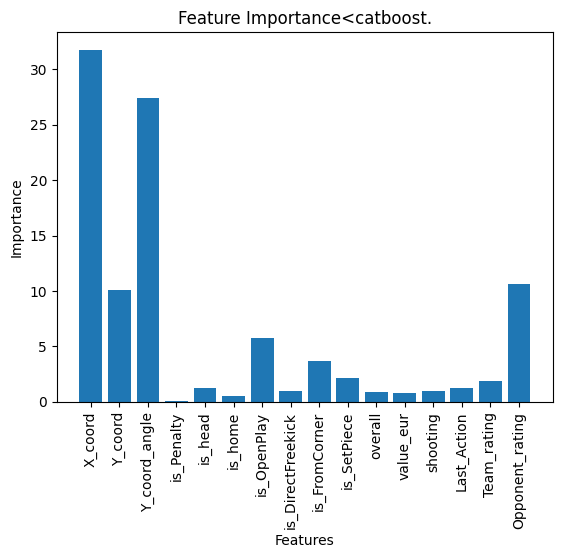

X_coord: 0.3176856823099586
Y_coord: 0.10062259543787005
Y_coord_angle: 0.2744904248391688
is_Penalty: 0.00037725084156611647
is_head: 0.012490377372335925
is_home: 0.005367088855580253
is_OpenPlay: 0.05723941720644228
is_DirectFreekick: 0.00980156833515589
is_FromCorner: 0.03674729395060771
is_SetPiece: 0.02164411933608931
overall: 0.008672796539429994
value_eur: 0.007926834593695807
shooting: 0.009675584032285113
Last_Action: 0.01255397362197282
Team_rating: 0.01826831920598448
Opponent_rating: 0.1064366735218569


In [392]:
# Calculating feature importance

def calculate_feature_importance(best_model):
    feature_importances = best_model.feature_importances_
    # Plot feature importance
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.xticks(range(len(feature_importances)), features.columns, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance'+str(best_model)[:10])
    plt.show()
    # Assign weights to features based on their importance
    feature_weights = feature_importances / feature_importances.sum()
    # Print feature weights
    for feature, weight in zip(features.columns, feature_weights):
        print(f"{feature}: {weight}")

calculate_feature_importance(xgb_s)
calculate_feature_importance(best_random_forest_model)
calculate_feature_importance(best_rf_model)
calculate_feature_importance(final_lgb_model)
calculate_feature_importance(final_adaboost_model)
calculate_feature_importance(final_catboost_model)
#calculate_feature_importance(lstm_model)

# calculate_feature_importance(xgb_s)
# calculate_feature_importance(random_forest_model_s)
# calculate_feature_importance(rf_model_s)
# calculate_feature_importance(lgb_model_s)
# calculate_feature_importance(adaboost_model_s)
# calculate_feature_importance(catboost_model_s)
    
    
#feature_importances = xgb_s.feature_importances_
#feature_importances = adaboost_model.feature_importances_
#feature_importances = lgb_model.feature_importances_
#feature_importances = catboost_model.feature_importances_
#feature_importances = rf_model.feature_importances_
#feature_importances = random_forest_model_s.feature_importances_



X_coord: 13.657375108429509
Y_coord: 0.22775260522849064
Y_coord_angle: 4.683025052453384
is_Penalty: 1.8592326636344065
is_head: -0.8364469071250671
is_home: 0.023549614999306922
is_OpenPlay: -0.41456488995248847
is_DirectFreekick: 0.361475799268069
is_FromCorner: -0.8670318592477526
is_SetPiece: -0.6250503400146583
overall: 0.5804514856093992
value_eur: 0.1772246787218135
shooting: 0.6587651029693844
Last_Action: 0.1866790027460069
Team_rating: 0.12401058271885974
Opponent_rating: -0.17341903733077196


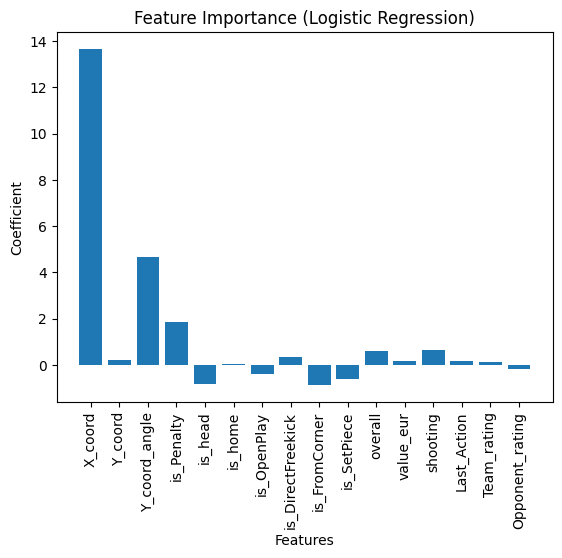

In [393]:
# Calculating feature importance (coefficients) of LOGISTIC REGRESSION MODEL
# feature_importance = logreg_model_s.coef_[0]
feature_importance = final_logreg_model.coef_[0]

for feature, importance in zip(features.columns, feature_importance):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), features.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

Permutation explainer: 12364it [13:55, 14.68it/s]                                                                      


Instance Features:
X_coord                    0.86
Y_coord                    0.40
Y_coord_angle              0.80
is_Penalty                 0.00
is_head                    0.00
is_home                    0.00
is_OpenPlay                1.00
is_DirectFreekick          0.00
is_FromCorner              0.00
is_SetPiece                0.00
overall                   72.00
value_eur            2900000.00
shooting                  61.00
Last_Action               10.00
Team_rating               80.00
Opponent_rating           83.00
Name: 34548, dtype: float64
SHAP Values:
.values =
array([ 0.06714273,  0.0800162 ,  0.02423048,  0.00601506,  0.03558177,
        0.03546802, -0.11859388,  0.05666154,  0.07480694,  0.0426814 ,
        0.0267894 , -0.02106018, -0.00963475, -0.03228577,  0.00505068,
       -0.00758702])

.base_values =
array([0.21858965])

.data =
array([0.85858586, 0.375     , 0.8       , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
  

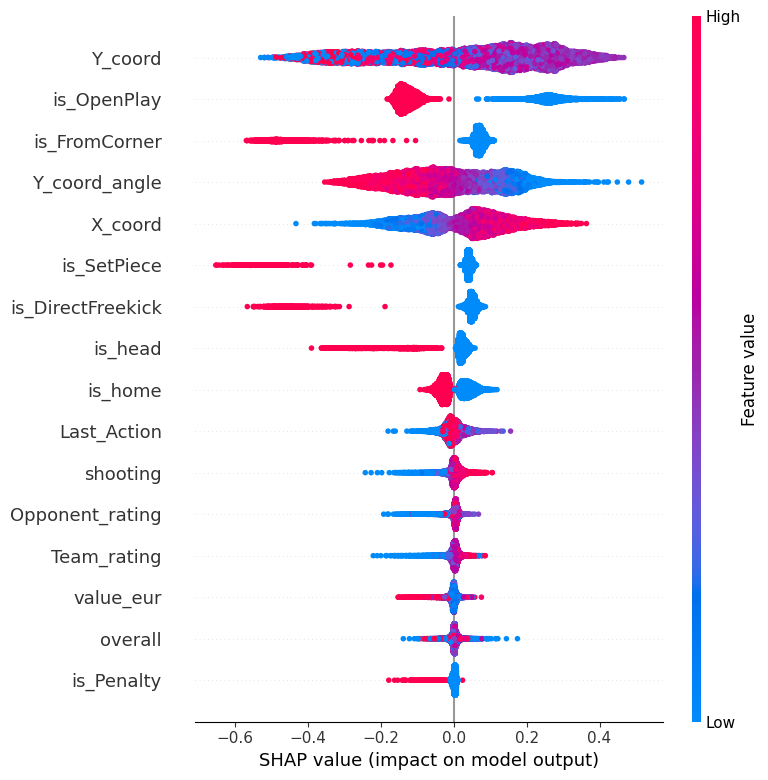

In [407]:
#FEATURE IMPORTANCE OF ANN MODEL


# Calculating SHAP values
explainer = shap.Explainer(ann_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Printing feature values for a specific instance (index)
instance_index = 0  # Change this to the desired instance index
instance_features = X_test.iloc[instance_index]
print("Instance Features:")
print(instance_features)

# Printing SHAP values for the same instance
shap_instance_values = shap_values[instance_index]
print("SHAP Values:")
print(shap_instance_values)

# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values, X_test_scaled, feature_names=features.columns)
plt.show()



In [396]:
#Loading xG values into the dataframe for each model

#xG_all_xgb = final_xgb_model.predict_proba(X_data_scaled)[:, 1]
xG_all_xgb = xgb_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_xgb'] = xG_all_xgb


xG_all_LR = final_logreg_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_LR = logreg_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LR'] = xG_all_LR


xG_all_RFR = best_random_forest_model.predict(X_data_scaled)
#xG_all_RFR = random_forest_model_s.predict(X_data_scaled)
data['xG_calc_RFR'] = xG_all_RFR

xG_all_RFC = best_rf_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_RFC = rf_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_RFC'] = xG_all_RFC


xG_all_ANN = best_ann_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_ANN = ann_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_ANN'] = xG_all_ANN

#xG_all_LGB = final_lgb_model.predict_proba(X_data_scaled)[:, 1]
xG_all_LGB = lgb_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LGB'] = xG_all_LGB


xG_all_adaboost = final_adaboost_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_adaboost = adaboost_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_adaboost'] = xG_all_adaboost


xG_all_catboost = final_catboost_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_catboost = catboost_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_catboost'] = xG_all_catboost



#reshaped_features = scaled_features.reshape(1, 1, scaled_features.shape[1])
X_data_reshaped = X_data_scaled.reshape(X_data_scaled.shape[0], 1, X_data_scaled.shape[1])
xG_all_LSTM = lstm_model.predict(X_data_reshaped)
data['xG_calc_LSTM'] = xG_all_LSTM


print("xG values of models loaded into the dataframe")



1932/1932 [==============================] - 5s 3ms/step
xG values of models loaded into the dataframe


In [397]:
# Split the data into training and testing sets before LSTM MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Apply oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardize the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


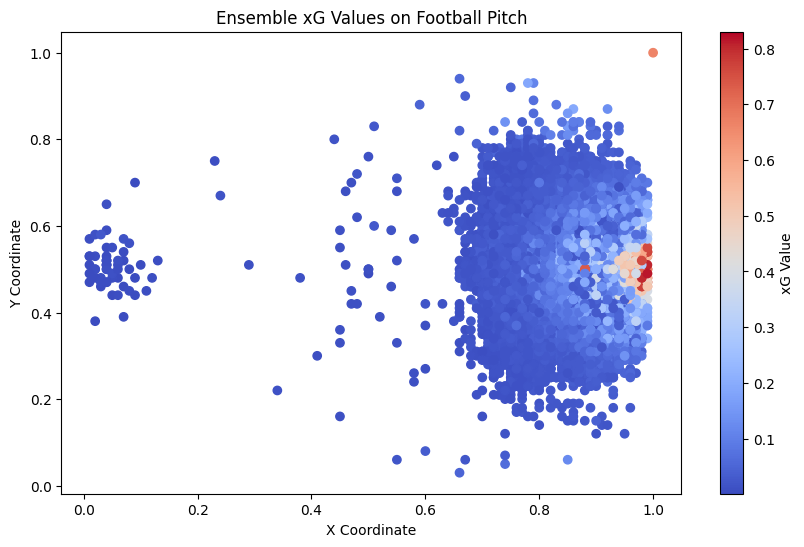

In [398]:
#CREATE AN ENSEMBLE MODEL TO PREDCIT THE xG VALUES

# Create an ensemble model of XGBoost and CatBoost
# ensemble_model = VotingClassifier([('xgb', final_xgb_model), ('lgbm', final_lgb_model)] , voting = 'soft')
ensemble_model = VotingClassifier([('xgb', final_xgb_model), ('ann', best_ann_model)] , voting = 'soft')

# Fit the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Calculate xG values using the ensemble model
xG_values_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]


# Plot xG values using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=xG_values_ensemble, cmap='coolwarm')
plt.colorbar(label='xG Value')
plt.title('Ensemble xG Values on Football Pitch')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


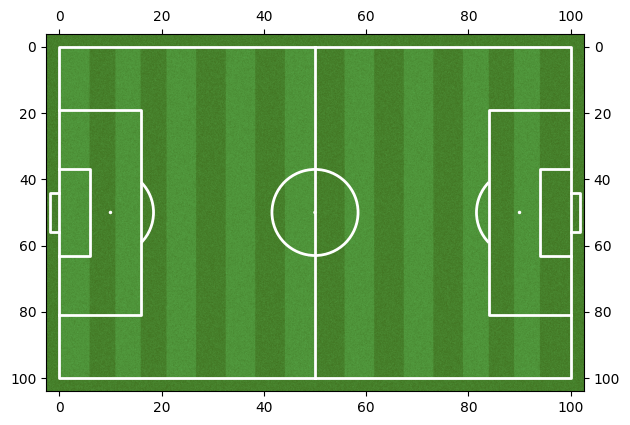

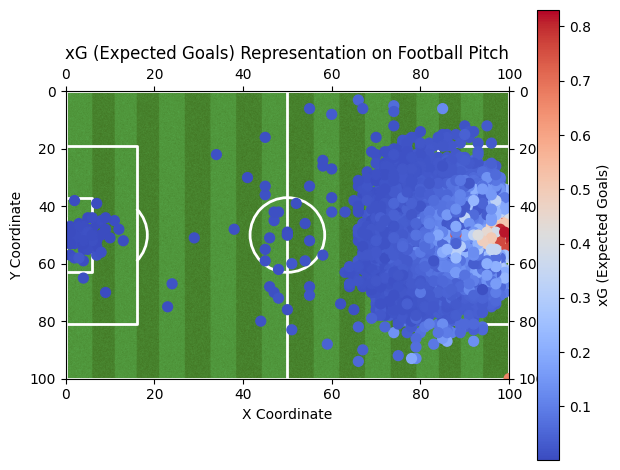

In [399]:
#FOOTBALL PITCH

def plot_football_pitch():
    #fig, ax = plt.subplots(figsize=(10, 6))
    pitch = Pitch(pitch_color='grass', stripe = True, pitch_type = 'wyscout', line_color = 'white', goal_type = 'box',label = True,  axis = True, tick = True)
    fig, ax = pitch.draw()
    #plt.show()
    
    # Plotting the football pitch
#     ax.plot([0, 1], [0, 0], color='black', linewidth=2)  # Goal line
#     ax.plot([0, 0], [0, 1], color='black', linewidth=2)  # Left touchline
#     ax.plot([1, 1], [0, 1], color='black', linewidth=2)  # Right touchline
#     ax.plot([0, 1], [1, 1], color='black', linewidth=2)  # Bottom line
    
    # Plotting the penalty area
#     ax.plot([0.25, 0.25], [1.00, 0.817], color='black', linewidth=2)  # Left goal box line
#     ax.plot([0.75, 0.75], [1.00, 0.817], color='black', linewidth=2)  # Right goal box line
#     ax.plot([0.25, 0.75], [0.817, 0.817], color='black', linewidth=2)  # Top goal box line
#     ax.plot([0.75, 0.75], [0, 0.183], color='black', linewidth=2)  # Right goal box line
#     ax.plot([0.25, 0.25], [0, 0.183], color='black', linewidth=2)  # Left goal box line
#     ax.plot([0.75, 0.25], [0.183, 0.183], color='black', linewidth=2)  # Top goal box line
    
    # Plotting the penalty spot
    #ax.scatter(0.885, 0.50, color='black', s=100)
    ax.scatter(88.5, 50, color='black', s=100)
    
    # Plotting the xG values
    sc = ax.scatter(X_test['X_coord']*100, X_test['Y_coord']*100, c=xG_values_ensemble, cmap='coolwarm', s=50)
    #cbar = plt.colorbar(scatter, ax=ax, label='xG (Expected Goals)')
    
    # Set the axis limits and labels
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('xG (Expected Goals) Representation on Football Pitch')
    
    cbar = plt.colorbar(sc)
    cbar.set_label('xG (Expected Goals)')
    
    plt.gca().invert_yaxis() 
    plt.show()

# Plotting the football pitch with xG values
pitch = Pitch(pitch_color='grass', stripe = True, pitch_type = 'wyscout', line_color = 'white', goal_type = 'box',label = True,  axis = True, tick = True)
fig, ax = pitch.draw()
plt.show()
plot_football_pitch()

In [400]:
output_file_path1 = "C:/Users/Vignesh Venkataraman/OneDrive/Desktop/Msc DATA SCIENCE/Dissertation/Dataframe_mod/modified_dataset_xg.csv"


data.to_csv(output_file_path, index=False)
print("Result Dataset exported")

Result Dataset exported


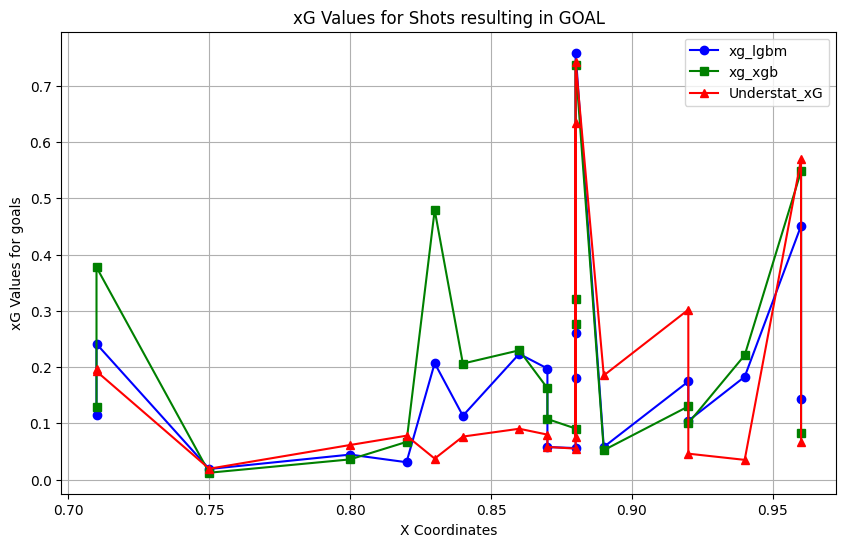

In [401]:
#Plotting line graphs of the models


# Filter rows where is_goal equals 1
goaldf = data[data['is_goal'] == 1]
goal_df = goaldf.tail(20)
goal_df = goal_df.sort_values(by=["X_coord", "Y_coord"])
# print(goal_df)



# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(goal_df['X_coord'], goal_df['xG_calc_LGB'], label='xg_lgbm', color='blue', marker='o')

#plt.plot(goal_df['X_coord'], goal_df['xG_calc_LR'], label='xg_LR', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_RFR'], label='xG_RFR', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_RFC'], label='xG_RFC', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_ANN'], label='xG_ANN', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_adaboost'], label='xG_adaboost', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_catboost'], label='xG_catboost', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_LSTM'], label='xG_LSTM', color='blue', marker='o')


plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')
plt.plot(goal_df['X_coord'], goal_df['xG'], label='Understat_xG', color='red', marker='^')

# Customize the plot
plt.title('xG Values for Shots resulting in GOAL')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

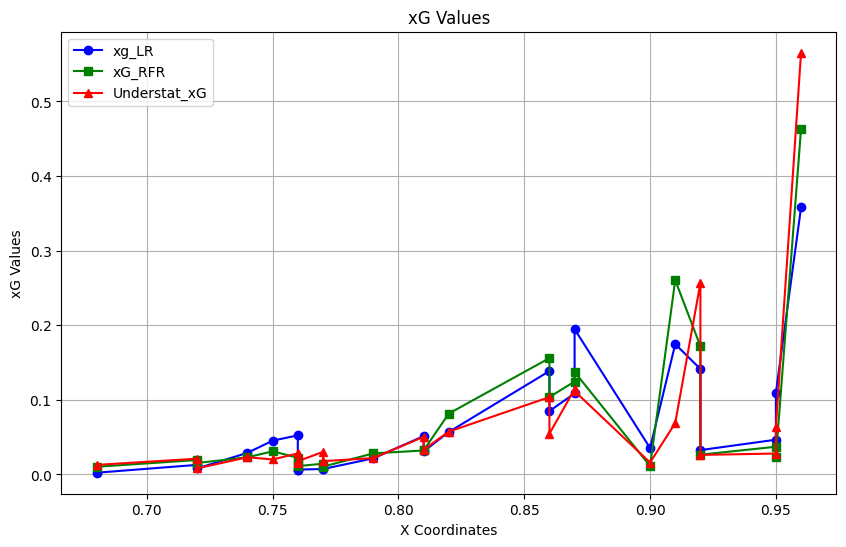

In [402]:
#Plotting line graphs of the models


# Filter rows where is_goal equals 1
goaldf_0 = data[data['is_goal'] == 0]
goaldf_0 = goaldf_0[goaldf_0["X_coord"] != 0.88]
goal_df_0 = goaldf_0.tail(25)
goal_df_0 = goal_df_0.sort_values(by=["X_coord", "Y_coord"])
# print(goal_df_0)



# Creating line plots
plt.figure(figsize=(10, 6))
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LGB'], label='xg_lgbm', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LR'], label='xg_LR', color='blue', marker='o')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_ANN'], label='xG_ANN', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_RFR'], label='xG_RFR', color='green', marker='s')
#plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_adaboost'], label='xG_adaboost', color='green', marker='s')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_catboost'], label='xG_catboost', color='green', marker='s')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LSTM'], label='xG_LSTM', color='green', marker='s')


# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG'], label='Understat_xG', color='red', marker='^')

# Customizing the plot
plt.title('xG Values')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

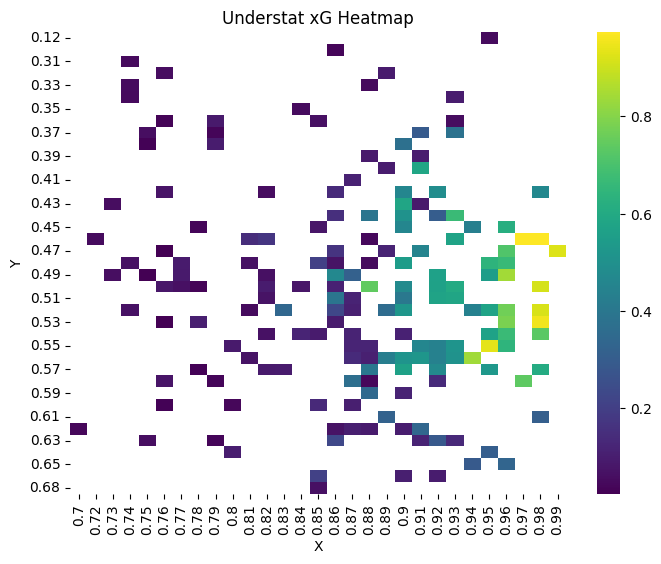

In [403]:
# Pivot the DataFrame to create a heatmap data structure of xG values

heat_data1 = data[data['Player name'] == "lionel messi"]
heat_data1 = heat_data1[heat_data1['is_goal'] == 1]
heat_data1 = heat_data1.drop_duplicates(subset=["X_coord", "Y_coord"])
heatmap_data = heat_data1.pivot(index="Y_coord", columns="X_coord", values="xG")
# heatmap_data = heat_data.pivot(index="X_coord", columns="Y_coord", values="xG")

# Creating a heatmap for xG values
plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar=True)
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
plt.title("Understat xG Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

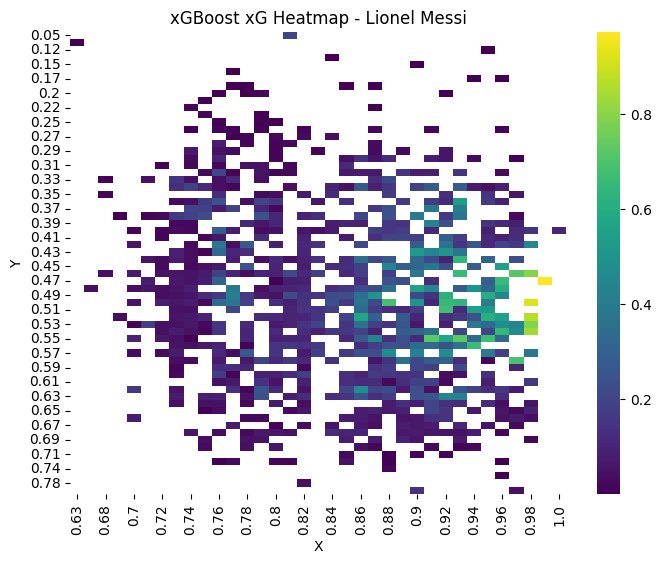

In [404]:
# Pivot the DataFrame to create a heatmap data structure of xG values

heat_data = data[data['Player name'] == "lionel messi"]
heat_data = heat_data.drop_duplicates(subset=["X_coord", "Y_coord"])
heatmap_data = heat_data.pivot(index="Y_coord", columns="X_coord", values="xG_calc_xgb")
# heatmap_data = heat_data.pivot(index="X_coord", columns="Y_coord", values="xG")

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar=True)
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
plt.title("xGBoost xG Heatmap - Lionel Messi")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

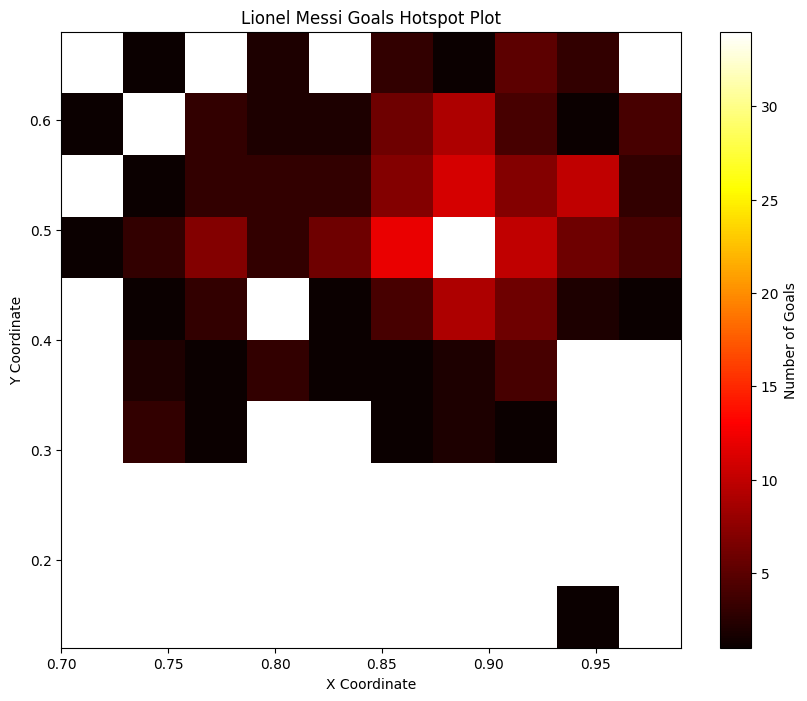

In [405]:
# Plotting hotspot for goals of Lionel Messi


hotspot_data1 = data[data['Player name'] == "lionel messi"]
hotspot_data1 = hotspot_data1[hotspot_data1['is_goal'] == 1]
plt.figure(figsize=(10, 8))
plt.hist2d(hotspot_data1["X_coord"], hotspot_data1["Y_coord"], bins=(10, 10), cmap="hot", cmin=1)
plt.colorbar(label="Number of Goals")
plt.title("Lionel Messi Goals Hotspot Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

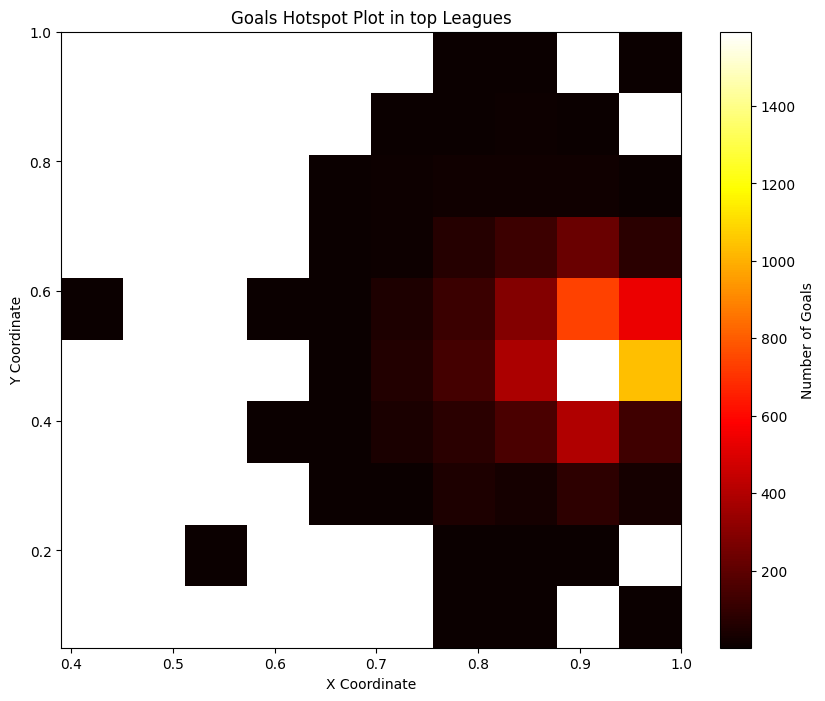

In [406]:
# Plot hotspot for goals

hotspot_data_all_goals = data[data['is_goal'] == 1]
plt.figure(figsize=(10, 8))
plt.hist2d(hotspot_data_all_goals["X_coord"], hotspot_data_all_goals["Y_coord"], bins=(10, 10), cmap="hot", cmin=1)
plt.colorbar(label="Number of Goals")
plt.title("Goals Hotspot Plot in top Leagues")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()